# HFL

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.modeling import models, fitting
from scipy.signal import find_peaks, savgol_filter
from astropy.time import Time
from astropy.coordinates import EarthLocation, AltAz, ICRS, Galactic, Angle
from astropy.coordinates import get_sun
import astropy.units as u
from PyAstronomy import pyasl
import math
from scipy.optimize import curve_fit


In [2]:
def old_lsr_velocity(az, el, lat, lon, alt, obs_time, v_obs):
    """
    Convert Azimuth/Elevation to LSR velocity correction.
    
    Parameters:
    az (float): Azimuth in degrees
    el (float): Elevation in degrees
    lat (float): Latitude of observer in degrees
    lon (float): Longitude of observer in degrees
    alt (float): Altitude of observer in meters
    obs_time (str): Observation time in 'YYYY-MM-DD HH:MM:SS' UTC format
    v_obs (array): Observed velocity from Doppler shift (km/s)
    
    Returns:
    array: LSR-corrected velocity (km/s)
    """
    # Define observer location
    location = EarthLocation(lat=lat*u.deg, lon=lon*u.deg, height=alt*u.m)
    
    # Convert observation time to Astropy Time object
    # Convert IST to UTC (IST is UTC+5:30)
    ist_time = Time(obs_time)
    utc_time = ist_time - 5.5 * u.hour
    time = utc_time
    
    # Compute Local Sidereal Time (LST)
    lst = time.sidereal_time('apparent', longitude=lon*u.deg)
    
    # Define AltAz frame
    altaz = AltAz(obstime=time, location=location)
    
    # Convert Az/El to RA/Dec
    source_altaz = AltAz(az=az*u.deg, alt=el*u.deg, obstime=time, location=location)
    from astropy.coordinates import SkyCoord
    source_altaz = SkyCoord(az=az*u.deg, alt=el*u.deg, frame=AltAz(obstime=time, location=location))
    source_radec = source_altaz.transform_to(ICRS)
    ra = source_radec.ra.deg  # Right Ascension
    dec = source_radec.dec.deg  # Declination

    print("RA: ", ra)
    print("DEC: ", dec)
    
    # Compute Barycentric correction
    #jd = pyasl.jdcnv(time)
    jd = time.jd  # Convert observation time to Julian Date
    corr, hjd = pyasl.helcorr(-lon, lat, alt, ra, dec, jd, debug=False)
    print("jd: ", jd)
    
    # Compute Solar Apex motion correction
    v_sun = 20.5  # km/s (Sun's peculiar velocity relative to LSR)
    sun_ra = math.radians(270.2)
    sun_dec = math.radians(28.7)
    obs_ra = math.radians(ra)
    obs_dec = math.radians(dec)
    
    a = math.cos(sun_dec) * math.cos(obs_dec)
    b = (math.cos(sun_ra) * math.cos(obs_ra)) + (math.sin(sun_ra) * math.sin(obs_ra))
    c = math.sin(sun_dec) * math.sin(obs_dec)
    v_rs = v_sun * ((a * b) + c)
    print("Corr: ", corr)
    print("V_rs: ", v_rs)
          
    # Compute final LSR velocity correction
    v_lsr = corr + v_rs  # Apply same convention as instructor
    
    # Compute LSR-corrected velocity
    subv_lsr_corrected = v_obs - v_lsr  # Standard convention
    
    return subv_lsr_corrected




  


In [3]:
# Gaussian function
def gaussian(x, amplitude, mean, sigma, shift):
    return amplitude * np.exp(-((x - mean)**2) / (2 * sigma**2)) + shift

# Sum of multiple Gaussians
def sum_of_gaussians(x, *params):
    n_gaussians = len(params) // 4  # 4 parameters per Gaussian
    y = np.zeros_like(x)
    for i in range(n_gaussians):
        amplitude = params[4 * i]
        mean = params[4 * i + 1]
        sigma = params[4 * i + 2]
        shift = params[4 * i + 3]
        y += gaussian(x, amplitude, mean, sigma, shift)
    return y

# Fit function
def fit_gaussians(x_data, y_data, n_gaussians, initial_guesses):
    if len(initial_guesses) != n_gaussians * 4:
        raise ValueError("Initial guesses must have 4 parameters per Gaussian (amp, mean, sigma, shift).")
    try:
        popt, _ = curve_fit(lambda x, *params: sum_of_gaussians(x, *params), x_data, y_data, p0=initial_guesses)
        return popt
    except Exception as e:
        print(f"Fitting failed: {e}")
        return None

In [4]:
def make_line(array, start, stop):
    avg = (array[start]+array[stop])/2
    arr = np.zeros(len(array))
    for i in range(len(array)):
        if i > start and i < stop:
            arr[i] = avg
        else:
            arr[i] = array[i]
    print(avg)
    return arr
    

In [6]:
# Load sky, ground, and source data
sky1 = "C:\\Users\\DELL\\OneDrive\\Desktop\\ProjH1\\python rtlsdr data\\v9\\s1.csv"
ground1 = "C:\\Users\\DELL\\OneDrive\\Desktop\\ProjH1\\python rtlsdr data\\v9\\g1.csv"


#source0 = "C:\\Users\\DELL\\OneDrive\\Desktop\\ProjH1\\python rtlsdr data\\v8\\0.csv"
#source10 = "C:\\Users\\DELL\\OneDrive\\Desktop\\ProjH1\\python rtlsdr data\\v8\\10.csv"
#source20 = "C:\\Users\\DELL\\OneDrive\\Desktop\\ProjH1\\python rtlsdr data\\v8\\20.csv"
source30 = "C:\\Users\\DELL\\OneDrive\\Desktop\\ProjH1\\python rtlsdr data\\v9\\30.csv"
source40 = "C:\\Users\\DELL\\OneDrive\\Desktop\\ProjH1\\python rtlsdr data\\v9\\40.csv"
source50 = "C:\\Users\\DELL\\OneDrive\\Desktop\\ProjH1\\python rtlsdr data\\v9\\50.csv"
source60 = "C:\\Users\\DELL\\OneDrive\\Desktop\\ProjH1\\python rtlsdr data\\v9\\60.csv"
source70 = "C:\\Users\\DELL\\OneDrive\\Desktop\\ProjH1\\python rtlsdr data\\v9\\70.csv"
source80 = "C:\\Users\\DELL\\OneDrive\\Desktop\\ProjH1\\python rtlsdr data\\v9\\80.csv"
source90 = "C:\\Users\\DELL\\OneDrive\\Desktop\\ProjH1\\python rtlsdr data\\v9\\90.csv"



sky_data1 = pd.read_csv(sky1)
ground_data1 = pd.read_csv(ground1)



#source_data0 = pd.read_csv(source0)
#source_data10 = pd.read_csv(source10)
#source_data20 = pd.read_csv(source20)
source_data30 = pd.read_csv(source30)
source_data40 = pd.read_csv(source40)
source_data50 = pd.read_csv(source50)
source_data60 = pd.read_csv(source60)
source_data70 = pd.read_csv(source70)
source_data80 = pd.read_csv(source80)
source_data90 = pd.read_csv(source90)




# Extract frequency and power values
f_s1 = (sky_data1["Frequency (Hz)"] / 1e6).values  # Convert to NumPy array
f_g1 = (ground_data1["Frequency (Hz)"] / 1e6).values



#f_0 = (source_data0["Frequency (Hz)"] / 1e6).values
#f_10 = (source_data10["Frequency (Hz)"] / 1e6).values
#f_20 = (source_data20["Frequency (Hz)"] / 1e6).values
f_30 = (source_data30["Frequency (Hz)"] / 1e6).values
f_40 = (source_data40["Frequency (Hz)"] / 1e6).values
f_50 = (source_data50["Frequency (Hz)"] / 1e6).values
f_60 = (source_data60["Frequency (Hz)"] / 1e6).values
f_70 = (source_data70["Frequency (Hz)"] / 1e6).values
f_80 = (source_data80["Frequency (Hz)"] / 1e6).values
f_90 = (source_data90["Frequency (Hz)"] / 1e6).values


s_p_1 = sky_data1["Power (dB)"]
g_p_1 = ground_data1["Power (dB)"]




#p_0 = source_data0["Power (dB)"]
#p_10 = source_data10["Power (dB)"]
#p_20 = source_data20["Power (dB)"]
p_30 = source_data30["Power (dB)"]
p_40 = source_data40["Power (dB)"]
p_50 = source_data50["Power (dB)"]
p_60 = source_data60["Power (dB)"]
p_70 = source_data70["Power (dB)"]
p_80 = source_data80["Power (dB)"]
p_90 = source_data90["Power (dB)"]



# ---- Convert dB to Linear Scale ----
P_g1 = 10 ** (g_p_1 / 10)
P_s1 = 10 ** (s_p_1 / 10)




#P_0 = 10 ** (p_0 / 10)
#P_10 = 10 ** (p_10 / 10)
#P_20 = 10 ** (p_20 / 10)
P_30 = 10 ** (p_30 / 10)
P_40 = 10 ** (p_40 / 10)
P_50 = 10 ** (p_50 / 10)
P_60 = 10 ** (p_60 / 10)
P_70 = 10 ** (p_70 / 10)
P_80 = 10 ** (p_80 / 10)
P_90 = 10 ** (p_90 / 10)




# ---- Baseline Correction (Optional) ----
pg1 = savgol_filter(P_g1, window_length=51, polyorder=3)
ps1 = savgol_filter(P_s1, window_length=51, polyorder=3)



#p0 = savgol_filter(P_0, window_length=51, polyorder=3)
#p10 = savgol_filter(P_10, window_length=51, polyorder=3)
#p20 = savgol_filter(P_20, window_length=51, polyorder=3)
p30 = savgol_filter(P_30, window_length=51, polyorder=3)
p40 = savgol_filter(P_40, window_length=51, polyorder=3)
p50 = savgol_filter(P_50, window_length=51, polyorder=3)
p60 = savgol_filter(P_60, window_length=51, polyorder=3)
p70 = savgol_filter(P_70, window_length=51, polyorder=3)
p80 = savgol_filter(P_80, window_length=51, polyorder=3)
p90 = savgol_filter(P_90, window_length=51, polyorder=3)


# 0 long

# 5 long

# 10 long

# 15 long

# 20 long

# 25 long

# 30 long

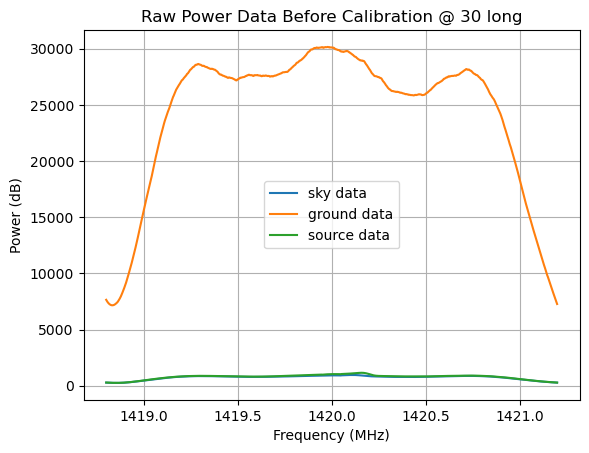

In [22]:
l1 = 30
plt.plot(f_s1, ps1, label="sky data")
plt.plot(f_g1, pg1, label="ground data")
plt.plot(f_30, p30, label="source data")
plt.legend()

plt.xlabel("Frequency (MHz)")
plt.ylabel("Power (dB)")
plt.title(f"Raw Power Data Before Calibration @ {l1} long")
plt.legend()
plt.grid()
plt.show()

3.9972901555023017


Text(0.5, 1.0, 'Tc @ 30 long')

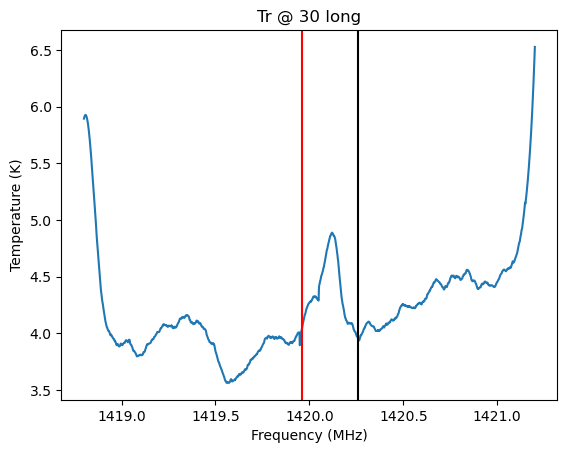

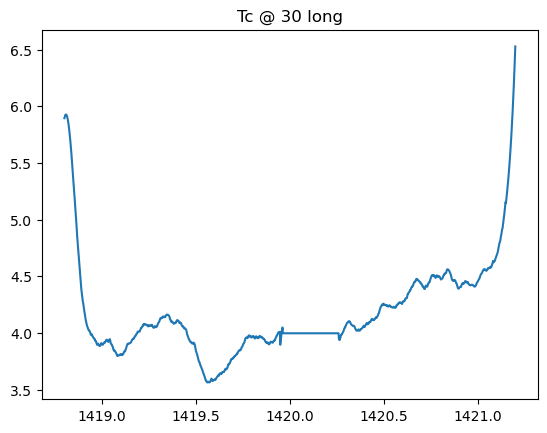

In [30]:
T_sky=5
T_gnd=300

# Compute receiver system temperature (T_r)
tr = (T_sky * (pg1 / ps1) - T_gnd) / (1 - (pg1 / ps1))

start1= 580
stop1 = 730


plt.figure()
plt.plot(f_s1, tr, label="receiver temp")
plt.axvline(f_s1[start1], color = 'red')
plt.axvline(f_s1[stop1], color = 'k')
plt.title(f"Tr @ {l1} long")
plt.xlabel("Frequency (MHz)")
plt.ylabel("Temperature (K)")


#Baseline Correction
tc= make_line(tr, start1, stop1)

plt.figure()
plt.plot(f_s1, tc, label="receiver temp")
plt.title(f"Tc @ {l1} long")

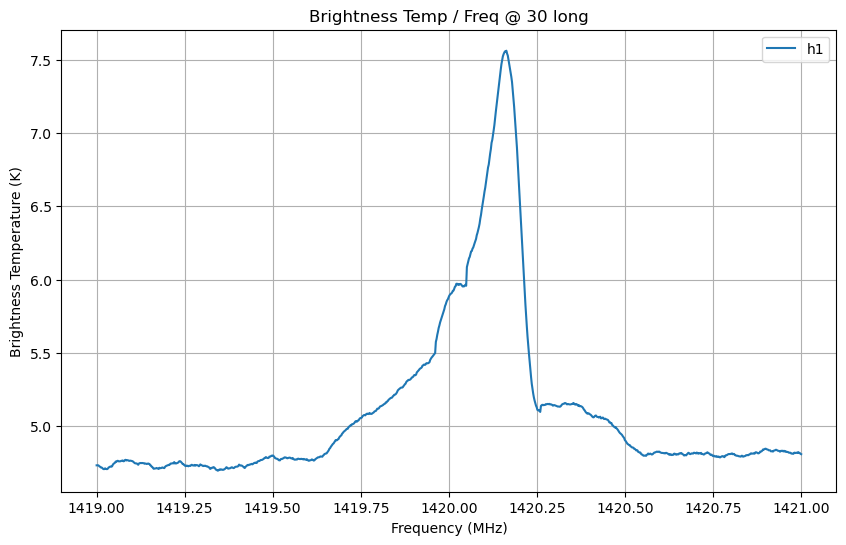

In [34]:
# Compute calibrated brightness temperature for the source
ts30 = ((T_gnd + tc) / (pg1 / p30)) - tc

t30 = ts30 - 0.5  # Shift values to bring them above zero

# Define frequency range to keep (adjust as needed)
freq_min = 1419.0  # MHz
freq_max = 1421.0  # MHz

# Apply mask to keep only frequencies in the selected range
mask = (f_30 >= freq_min) & (f_30 <= freq_max)

# Trim the frequency and brightness temperature data
f30 = f_30[mask]
tb30 = t30[mask]

# Plot the trimmed data
plt.figure(figsize=(10,6))
plt.plot(f30, tb30, label="h1")
plt.xlabel("Frequency (MHz)")
plt.ylabel("Brightness Temperature (K)")
plt.title(f"Brightness Temp / Freq @ {l1} long")
plt.legend()
plt.grid()
plt.show()


Peak Velocity: 51.21 km/s, Peak Temperature: 7.56 K


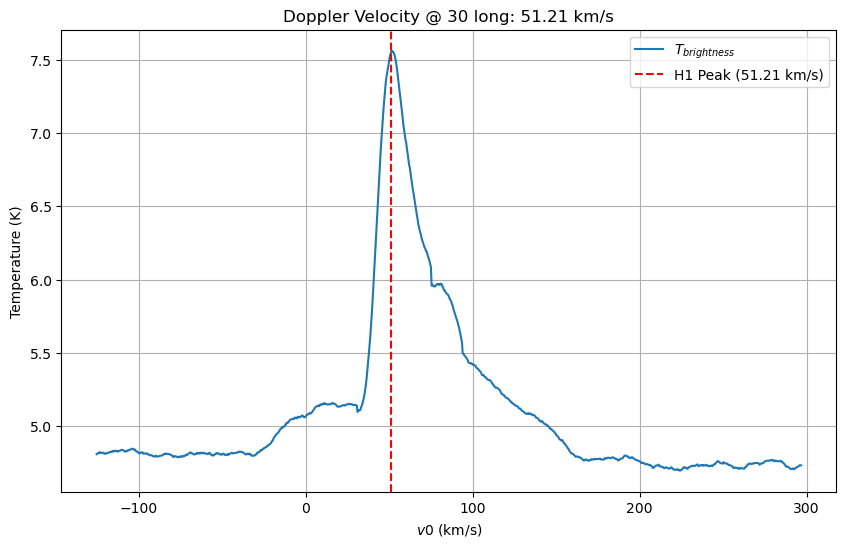

In [36]:
c = 299792.458

v30 = c* (1- f30/1420.405751768)

# Find highest peak and corresponding velocity
peak_idx = np.argmax(tb30)
peak_velocity = v30[peak_idx]
peak_temperature = tb30[peak_idx]

print(f"Peak Velocity: {peak_velocity:.2f} km/s, Peak Temperature: {peak_temperature:.2f} K")


plt.figure(figsize=(10,6))
plt.grid()
plt.plot(v30, tb30, label='$T_{brightness}$')
plt.axvline(peak_velocity, color="red", linestyle="dashed", label=f"H1 Peak ({peak_velocity:.2f} km/s)")
#plt.xticks(range(-250,250,50))
plt.title(f"Doppler Velocity @ {l1} long: {peak_velocity:.2f} km/s")
plt.xlabel('$v0$ (km/s)')
plt.ylabel('Temperature (K)')
plt.legend()
plt.show()

In [40]:
#!/usr/bin/env python
# coding: utf-8

# In[9]:

# PyAstronomy package requireq: https://pyastronomy.readthedocs.io/en/latest/index.html

from __future__ import print_function, division
from PyAstronomy import pyasl
import math
import datetime

# Coordinates of telescope
longitude = 78.2634
latitude = 18.0460
altitude = 554

# Coordinates of source (RA2000, DEC2000) RA_hr RA_min RA_sec DEC_deg DEC_min DEC_sec. Note DEC must be signed + or -.
hd1 = "18 44 36.34 -1 47 34.8"
obs_ra_2000, obs_dec_2000 = pyasl.coordsSexaToDeg(hd1)

# Time of observation converted to Julian Date
dt = datetime.datetime(2025, 3, 15, 2, 52, 00)
jd = pyasl.jdcnv(dt)

# Calculate barycentric correction (debug=True show
# various intermediate results)
corr, hjd = pyasl.helcorr(longitude, latitude, altitude, obs_ra_2000, obs_dec_2000, jd, debug=True)

#print("Barycentric correction [km/s]: ", corr)
#print("Heliocentric Julian day: ", hjd)

# Calculate LSR correction
v_sun = 20.5 # peculiar velocity (km/s) of sun w.r.t. LSR (The Solar Apex. Nature 162, 920 (1948). https://doi.org/10.1038/162920a0)
# solar apex
sun_ra = math.radians(270.2)
sun_dec = math.radians(28.7)

obs_dec = math.radians(obs_dec_2000)
obs_ra = math.radians(obs_ra_2000)

# equation from https://icts-yebes.oan.es/reports/doc/IT-CDT-2014-10.pdf
a = math.cos(sun_dec) * math.cos(obs_dec)
b = (math.cos(sun_ra) * math.cos(obs_ra)) + (math.sin(sun_ra) * math.sin(obs_ra))
c = math.sin(sun_dec) * math.sin(obs_dec)
v_rs = v_sun * ((a * b) + c)

v_lsr = corr + v_rs
print("LSR correction [km/s]: ", -v_lsr)
print("Positive value means receding (redshift) source, negative value means approaching (blueshift) source")
print("lsr: ", v_lsr)



----- HELCORR.PRO - DEBUG INFO - START ----
(obs_long (East positive),obs_lat,obs_alt) Observatory coordinates [deg,m]:  78.2634 18.046 554
(ra,dec) Object coordinates (for epoch 2000.0) [deg]:  281.15141666666665 -1.793
(ra,dec) Object coordinates (precessed to epoch 2025.291096) [deg]:  281.47976796826276 -1.7653729830946943
(ut) Universal time (middle of exposure) [hrs]:  2.8666666634380817
(jd) Julian date (middle of exposure) (JD):  2460749.6194444443
(hjd) Heliocentric Julian date (middle of exposure) (HJD):  2460749.617799436
(gmst) Greenwich mean sidereal time [hrs]:  14.397970401005182
(lmst) Local mean sidereal time [hrs]:  19.61553040100523
(dlat) Latitude correction [deg]:  -406.9784513200719
(lat) Geocentric latitude of observer [deg]:  17.932950430188868
(r) Distance of observer from center of earth [m]:  6376701.943730833
(v) Rotational velocity of earth at the position of the observer [km/s]:  0.4649964934974371
(vdiurnal) Projected earth rotation and earth-moon revolu

The maximum velocity is  111.47937193771398


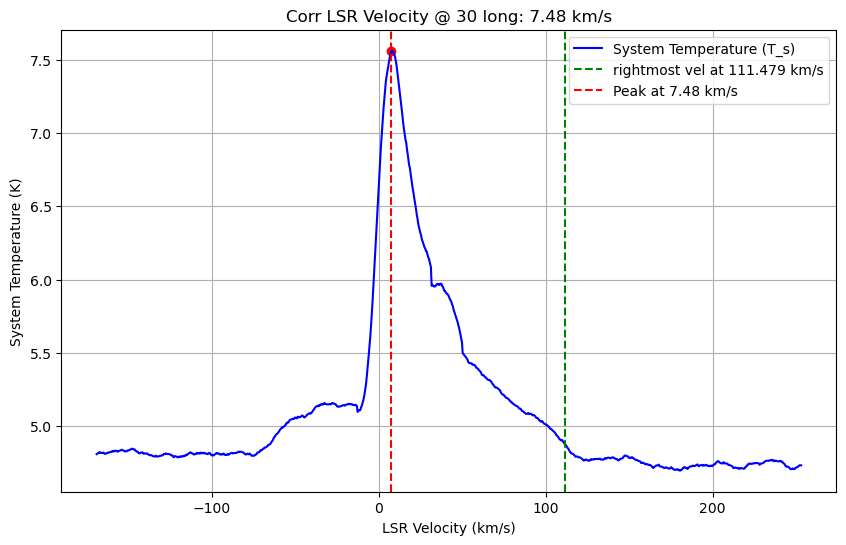

Peak System Temperature: 7.56 K at LSR Velocity: 7.48 km/s


In [42]:
#v_lsr_final = compute_lsr_velocity(azimuth, elevation, latitude, longitude, altitude, obs_time, v_obs)
#sub
#v_lsr30 = sub_lsr_velocity(134, 61, 18, 78, 474, "2025-03-8 6:28:00", v30)
v_lsr30 = v30 - v_lsr

# Unpack tuple if necessary
if isinstance(v_lsr30, tuple):
    v_lsr30 = v_lsr30[0]  # Select the first array (or second if needed)

# Ensure `v_lsr90` is an array and matches `tb90`
if len(v_lsr30) == len(tb30):
    peak_index = np.argmax(tb30)
    peak_velocity = v_lsr30[peak_index]  # No more tuple issue
    peak_temp = tb30[peak_index]
else:
    print("Mismatch in lengths! Check data shape.")

# Find the rightmost velocity using the given method
max_temp = tb30.max()  # Find maximum system temperature
max_i = list(tb30).index(max_temp)  # Find its index
v_max = v_lsr30[max_i]
ri_vel= v_max+104
print('The maximum velocity is ',ri_vel)
# Plot T_s vs. LSR Velocity
plt.figure(figsize=(10,6))
plt.plot(v_lsr30, tb30, label='System Temperature (T_s)', linestyle='solid', color='blue')
plt.title(f"right most vel @ {l1} long: {ri_vel:.2f} km/s")
plt.axvline(x=ri_vel, color='green', linestyle='dashed', label= f'rightmost vel at {ri_vel:.3f} km/s')


# Mark the peak
plt.axvline(x=peak_velocity, color='red', linestyle='dashed', label=f'Peak at {peak_velocity:.2f} km/s')
plt.scatter(peak_velocity, peak_temp, color='red', marker='o')

plt.xlabel("LSR Velocity (km/s)")
plt.ylabel("System Temperature (K)")
plt.title(f"Corr LSR Velocity @ {l1} long: {peak_velocity:.2f} km/s")
plt.legend()
plt.grid()
plt.show()

# Print peak values
print(f"Peak System Temperature: {peak_temp:.2f} K at LSR Velocity: {peak_velocity:.2f} km/s")

In [44]:
#sub
# Your data (Replace with actual variables)
x_data = v_lsr30  # LSR velocity
y_data = tb30          # Brightness Temperature

# Number of Gaussians to fit
n_gaussians = 6  # Adjust as needed

# Initial guesses [amp1, mean1, sigma1, shift1, amp2, mean2, sigma2, shift2, ...]
initial_guesses = [18, 6, 10, 0,  8, 40, 6, 0,  2.5, -40, 6, 0,  5.5, 55, 6, 0,  1, 135, 6, 0,  1, 110, 6, 0]  # Adjust manually

# Fit the data
popt = fit_gaussians(x_data, y_data, n_gaussians, initial_guesses)

# Plot results
if popt is not None:
    fitted_y = sum_of_gaussians(x_data, *popt)
    residuals = y_data - fitted_y  # Compute residuals

    plt.figure(figsize=(10, 6))

    # Plot original data and fit
    plt.plot(2, 1, 1)
    plt.scatter(x_data, y_data, s=10, label="$T_s$ (Observed)", color="blue")
    plt.plot(x_data, fitted_y, label="Fitted Gaussians", color="red")
    plt.axvline(popt[1], color='green', linestyle='dotted', label=f'Peak 1 at {popt[1]:.2f} km/s')
   # plt.axvline(popt[5], color='purple', linestyle='dotted', label=f'Peak 2 at {popt[5]:.2f} km/s')
    plt.legend()
    plt.xlabel('$v_{LSR}$ (km/s)')
    plt.ylabel('Temperature (K)')
    plt.title(f"Gaussian Fit @ {l1} long")
    plt.grid()

    # Plot residuals
    plt.figure(figsize=(10, 6))
    plt.plot(2, 1, 2)
    plt.scatter(x_data, residuals, s=10, color='black', label="Residuals")
    plt.axhline(0, color='red', linestyle='dashed')
    plt.xlabel('$v_{LSR}$ (km/s)')
    plt.ylabel('Residuals (K)')
    plt.title(f"Resisuals of Fit @ {l1} long")
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

    print(f"Peak 1 Velocity: {popt[1]:.2f} km/s")
    #print(f"Peak 2 Velocity: {popt[5]:.2f} km/s")



Fitting failed: Optimal parameters not found: Number of calls to function has reached maxfev = 5000.


# 35 long

# 40 long

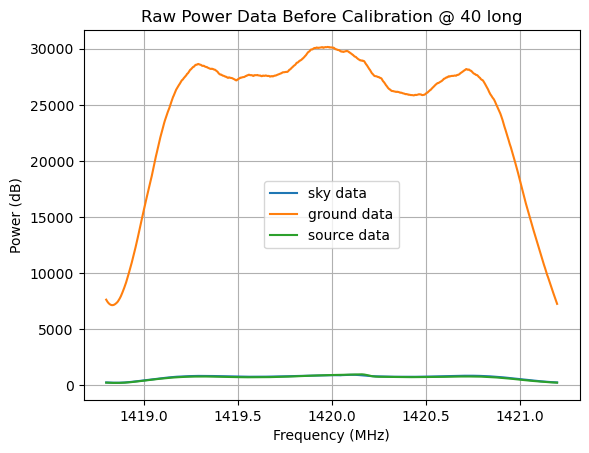

In [50]:
l1 = 40
plt.plot(f_s1, ps1, label="sky data")
plt.plot(f_g1, pg1, label="ground data")
plt.plot(f_40, p40, label="source data")
plt.legend()

plt.xlabel("Frequency (MHz)")
plt.ylabel("Power (dB)")
plt.title(f"Raw Power Data Before Calibration @ {l1} long")
plt.legend()
plt.grid()
plt.show()

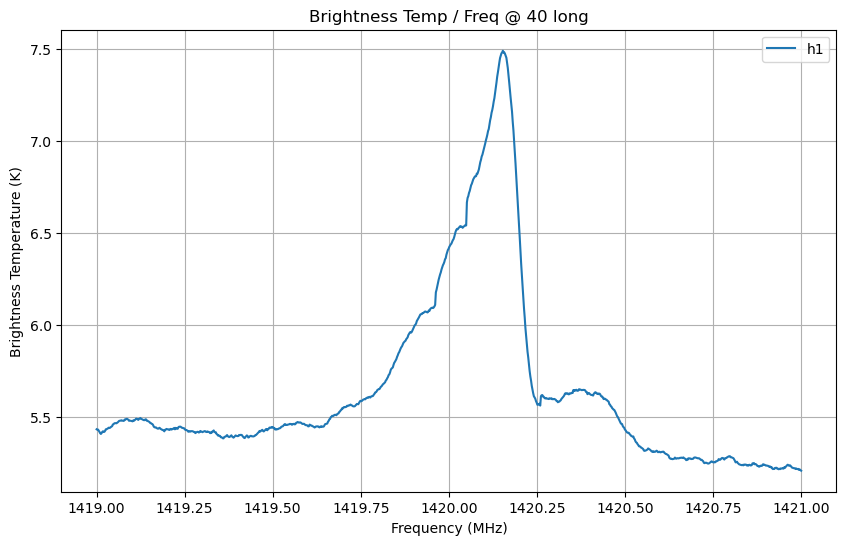

In [54]:
# Compute calibrated brightness temperature for the source
ts40 = ((T_gnd + tc) / (pg1 / p40)) - tc

t40 = ts40 + 1  # Shift values to bring them above zero

# Define frequency range to keep (adjust as needed)
freq_min = 1419.0  # MHz
freq_max = 1421.0  # MHz

# Apply mask to keep only frequencies in the selected range
mask = (f_40 >= freq_min) & (f_40 <= freq_max)

# Trim the frequency and brightness temperature data
f40 = f_40[mask]
tb40 = t40[mask]

# Plot the trimmed data
plt.figure(figsize=(10,6))
plt.plot(f40, tb40, label="h1")
plt.xlabel("Frequency (MHz)")
plt.ylabel("Brightness Temperature (K)")
plt.title(f"Brightness Temp / Freq @ {l1} long")
plt.legend()
plt.grid()
plt.show()


Peak Velocity: 53.32 km/s, Peak Temperature: 7.49 K


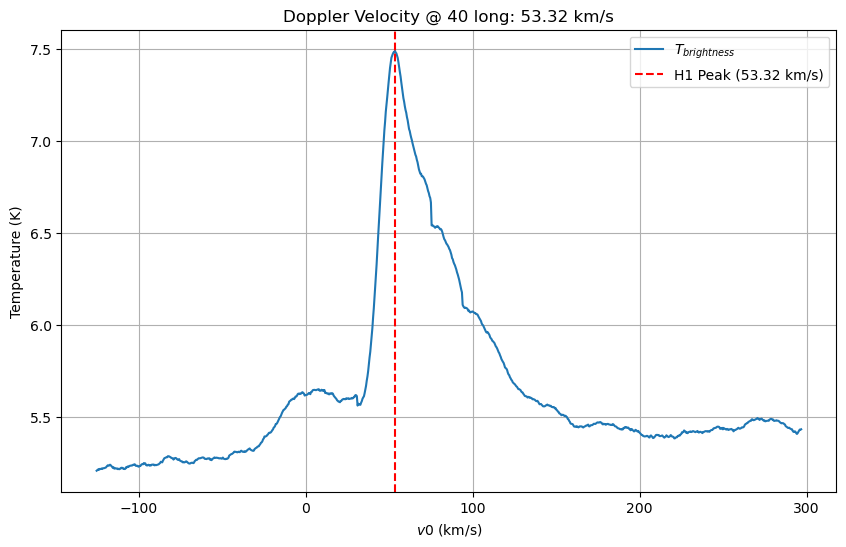

In [56]:
c = 299792.458

v40 = c* (1- f40/1420.405751768)

# Find highest peak and corresponding velocity
peak_idx = np.argmax(tb40)
peak_velocity = v40[peak_idx]
peak_temperature = tb40[peak_idx]

print(f"Peak Velocity: {peak_velocity:.2f} km/s, Peak Temperature: {peak_temperature:.2f} K")


plt.figure(figsize=(10,6))
plt.grid()
plt.plot(v40, tb40, label='$T_{brightness}$')
plt.axvline(peak_velocity, color="red", linestyle="dashed", label=f"H1 Peak ({peak_velocity:.2f} km/s)")
#plt.xticks(range(-250,250,50))
plt.title(f"Doppler Velocity @ {l1} long: {peak_velocity:.2f} km/s")
plt.xlabel('$v0$ (km/s)')
plt.ylabel('Temperature (K)')
plt.legend()
plt.show()

In [62]:
#!/usr/bin/env python
# coding: utf-8

# In[9]:

# PyAstronomy package requireq: https://pyastronomy.readthedocs.io/en/latest/index.html

from __future__ import print_function, division
from PyAstronomy import pyasl
import math
import datetime

# Coordinates of telescope
longitude = 78.2634
latitude = 18.0460
altitude = 554

# Coordinates of source (RA2000, DEC2000) RA_hr RA_min RA_sec DEC_deg DEC_min DEC_sec. Note DEC must be signed + or -.
hd1 = "19 05 47.21 +6 32 36.5"
obs_ra_2000, obs_dec_2000 = pyasl.coordsSexaToDeg(hd1)

# Time of observation converted to Julian Date
dt = datetime.datetime(2025, 3, 15, 2, 52, 00)
jd = pyasl.jdcnv(dt)

# Calculate barycentric correction (debug=True show
# various intermediate results)
corr, hjd = pyasl.helcorr(longitude, latitude, altitude, obs_ra_2000, obs_dec_2000, jd, debug=True)

#print("Barycentric correction [km/s]: ", corr)
#print("Heliocentric Julian day: ", hjd)

# Calculate LSR correction
v_sun = 20.5 # peculiar velocity (km/s) of sun w.r.t. LSR (The Solar Apex. Nature 162, 920 (1948). https://doi.org/10.1038/162920a0)
# solar apex
sun_ra = math.radians(270.2)
sun_dec = math.radians(28.7)

obs_dec = math.radians(obs_dec_2000)
obs_ra = math.radians(obs_ra_2000)

# equation from https://icts-yebes.oan.es/reports/doc/IT-CDT-2014-10.pdf
a = math.cos(sun_dec) * math.cos(obs_dec)
b = (math.cos(sun_ra) * math.cos(obs_ra)) + (math.sin(sun_ra) * math.sin(obs_ra))
c = math.sin(sun_dec) * math.sin(obs_dec)
v_rs = v_sun * ((a * b) + c)

v_lsr = corr + v_rs
print("LSR correction [km/s]: ", -v_lsr)
print("Positive value means receding (redshift) source, negative value means approaching (blueshift) source")
print("lsr: ", v_lsr)



----- HELCORR.PRO - DEBUG INFO - START ----
(obs_long (East positive),obs_lat,obs_alt) Observatory coordinates [deg,m]:  78.2634 18.046 554
(ra,dec) Object coordinates (for epoch 2000.0) [deg]:  286.44670833333333 6.543472222222222
(ra,dec) Object coordinates (precessed to epoch 2025.291096) [deg]:  286.7552456875284 6.583699782866932
(ut) Universal time (middle of exposure) [hrs]:  2.8666666634380817
(jd) Julian date (middle of exposure) (JD):  2460749.6194444443
(hjd) Heliocentric Julian date (middle of exposure) (HJD):  2460749.61734623
(gmst) Greenwich mean sidereal time [hrs]:  14.397970401005182
(lmst) Local mean sidereal time [hrs]:  19.61553040100523
(dlat) Latitude correction [deg]:  -406.9784513200719
(lat) Geocentric latitude of observer [deg]:  17.932950430188868
(r) Distance of observer from center of earth [m]:  6376701.943730833
(v) Rotational velocity of earth at the position of the observer [km/s]:  0.4649964934974371
(vdiurnal) Projected earth rotation and earth-moon

The maximum velocity is  105.38965745220557


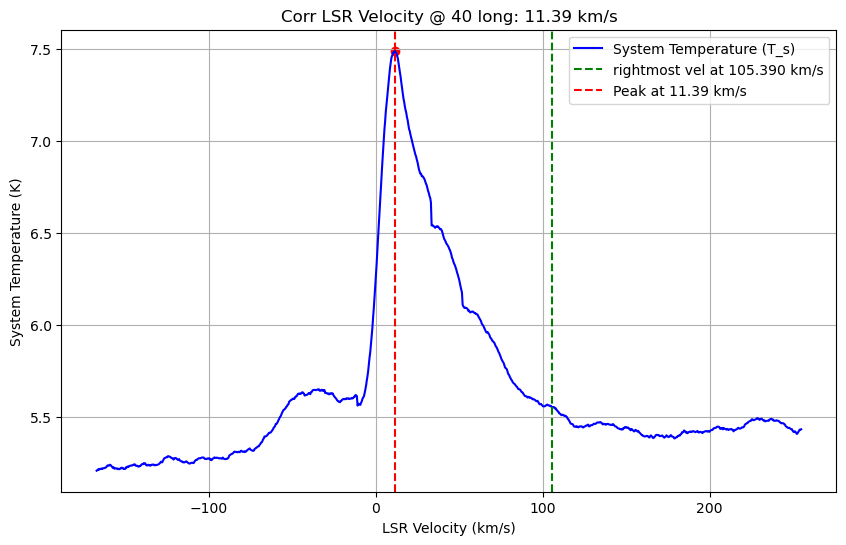

Peak System Temperature: 7.49 K at LSR Velocity: 11.39 km/s


In [64]:
#v_lsr_final = compute_lsr_velocity(azimuth, elevation, latitude, longitude, altitude, obs_time, v_obs)
#sub
#v_lsr40 = sub_lsr_velocity(115, 65, 18, 78, 474, "2025-03-12 6:36:00", v40)
v_lsr40 = v40 - v_lsr

# Unpack tuple if necessary
if isinstance(v_lsr40, tuple):
    v_lsr40 = v_lsr40[0]  # Select the first array (or second if needed)

# Ensure `v_lsr90` is an array and matches `tb90`
if len(v_lsr40) == len(tb40):
    peak_index = np.argmax(tb40)
    peak_velocity = v_lsr40[peak_index]  # No more tuple issue
    peak_temp = tb40[peak_index]
else:
    print("Mismatch in lengths! Check data shape.")

# Find the rightmost velocity using the given method
max_temp = tb40.max()  # Find maximum system temperature
max_i = list(tb40).index(max_temp)  # Find its index
v_max = v_lsr40[max_i]
ri_vel= v_max+94
print('The maximum velocity is ',ri_vel)
# Plot T_s vs. LSR Velocity
plt.figure(figsize=(10,6))
plt.plot(v_lsr40, tb40, label='System Temperature (T_s)', linestyle='solid', color='blue')
plt.title(f"right most vel @ {l1} long: {ri_vel:.2f} km/s")
plt.axvline(x=ri_vel, color='green', linestyle='dashed', label= f'rightmost vel at {ri_vel:.3f} km/s')


# Mark the peak
plt.axvline(x=peak_velocity, color='red', linestyle='dashed', label=f'Peak at {peak_velocity:.2f} km/s')
plt.scatter(peak_velocity, peak_temp, color='red', marker='o')

plt.xlabel("LSR Velocity (km/s)")
plt.ylabel("System Temperature (K)")
plt.title(f"Corr LSR Velocity @ {l1} long: {peak_velocity:.2f} km/s")
plt.legend()
plt.grid()
plt.show()

# Print peak values
print(f"Peak System Temperature: {peak_temp:.2f} K at LSR Velocity: {peak_velocity:.2f} km/s")

In [66]:
#sub
# Your data (Replace with actual variables)
x_data = v_lsr40  # LSR velocity
y_data = tb40          # Brightness Temperature

# Number of Gaussians to fit
n_gaussians = 6  # Adjust as needed

# Initial guesses [amp1, mean1, sigma1, shift1, amp2, mean2, sigma2, shift2, ...]
initial_guesses = [16, 11, 10, 0, 2.5, -40, 10, 0,  9, 45, 10, 0,  6.5, 55, 10, 0,  1, 100, 6, 0,  1, 140, 6, 0]  # Adjust manually

# Fit the data
popt = fit_gaussians(x_data, y_data, n_gaussians, initial_guesses)

# Plot results
if popt is not None:
    fitted_y = sum_of_gaussians(x_data, *popt)
    residuals = y_data - fitted_y  # Compute residuals

    plt.figure(figsize=(10, 6))

    # Plot original data and fit
    plt.plot(2, 1, 1)
    plt.scatter(x_data, y_data, s=10, label="$T_s$ (Observed)", color="blue")
    plt.plot(x_data, fitted_y, label="Fitted Gaussians", color="red")
    plt.axvline(popt[1], color='green', linestyle='dotted', label=f'Peak 1 at {popt[1]:.2f} km/s')
   # plt.axvline(popt[5], color='purple', linestyle='dotted', label=f'Peak 2 at {popt[5]:.2f} km/s')
    plt.legend()
    plt.xlabel('$v_{LSR}$ (km/s)')
    plt.ylabel('Temperature (K)')
    plt.title(f"Gaussian Fit @ {l1} long")
    plt.grid()

    # Plot residuals
    plt.figure(figsize=(10, 6))
    plt.plot(2, 1, 2)
    plt.scatter(x_data, residuals, s=10, color='black', label="Residuals")
    plt.axhline(0, color='red', linestyle='dashed')
    plt.xlabel('$v_{LSR}$ (km/s)')
    plt.ylabel('Residuals (K)')
    plt.title(f"Resisuals of Fit @ {l1} long")
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

    print(f"Peak 1 Velocity: {popt[1]:.2f} km/s")
    #print(f"Peak 2 Velocity: {popt[5]:.2f} km/s")



Fitting failed: Optimal parameters not found: Number of calls to function has reached maxfev = 5000.


# 45 long

# 50 long

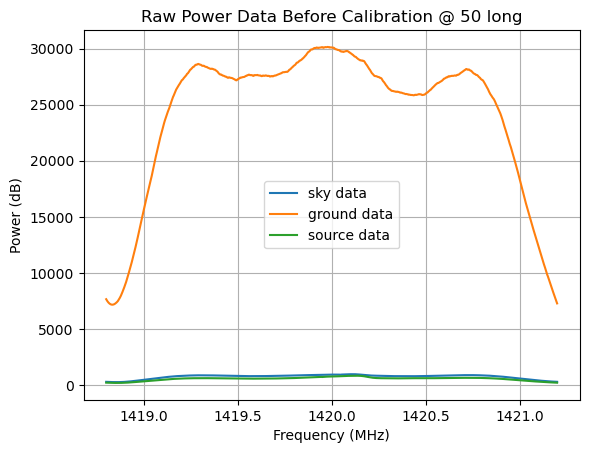

In [68]:
l1 = 50
plt.plot(f_s1, ps1, label="sky data")
plt.plot(f_g1, pg1, label="ground data")
plt.plot(f_50, p50, label="source data")
plt.legend()

plt.xlabel("Frequency (MHz)")
plt.ylabel("Power (dB)")
plt.title(f"Raw Power Data Before Calibration @ {l1} long")
plt.legend()
plt.grid()
plt.show()

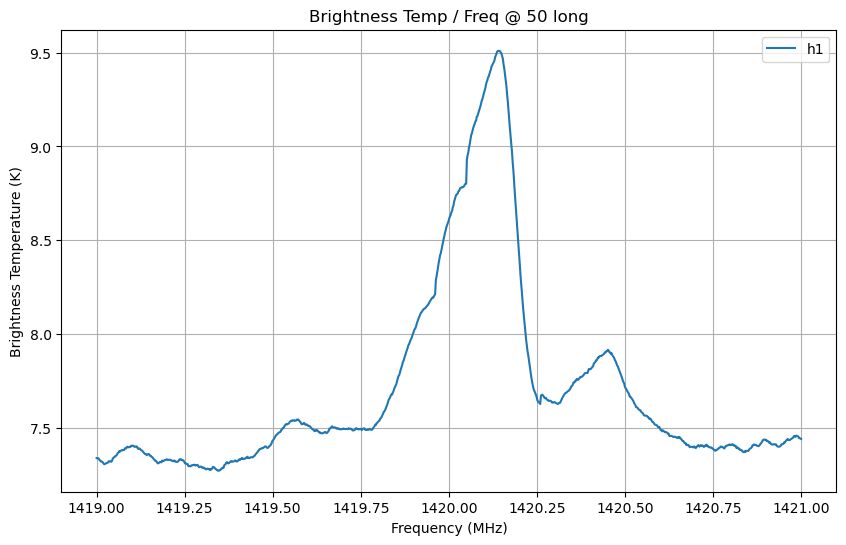

In [70]:
# Compute calibrated brightness temperature for the source
ts50 = ((T_gnd + tc) / (pg1 / p50)) - tc

t50 = ts50 + 5  # Shift values to bring them above zero

# Define frequency range to keep (adjust as needed)
freq_min = 1419.0  # MHz
freq_max = 1421.0  # MHz

# Apply mask to keep only frequencies in the selected range
mask = (f_50 >= freq_min) & (f_50 <= freq_max)

# Trim the frequency and brightness temperature data
f50 = f_50[mask]
tb50 = t50[mask]

# Plot the trimmed data
plt.figure(figsize=(10,6))
plt.plot(f50, tb50, label="h1")
plt.xlabel("Frequency (MHz)")
plt.ylabel("Brightness Temperature (K)")
plt.title(f"Brightness Temp / Freq @ {l1} long")
plt.legend()
plt.grid()
plt.show()


Peak Velocity: 55.86 km/s, Peak Temperature: 9.51 K


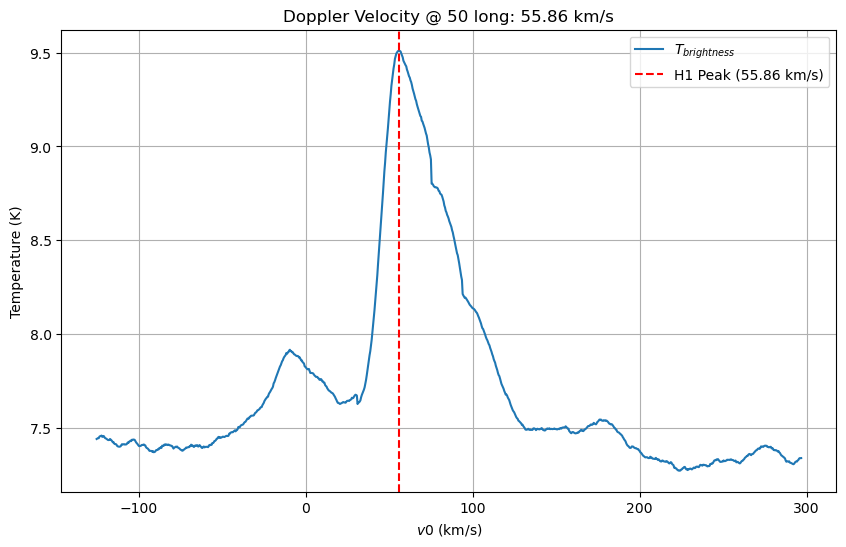

In [72]:
c = 299792.458

v50 = c* (1- f50/1420.405751768)

# Find highest peak and corresponding velocity
peak_idx = np.argmax(tb50)
peak_velocity = v50[peak_idx]
peak_temperature = tb50[peak_idx]

print(f"Peak Velocity: {peak_velocity:.2f} km/s, Peak Temperature: {peak_temperature:.2f} K")


plt.figure(figsize=(10,6))
plt.grid()
plt.plot(v50, tb50, label='$T_{brightness}$')
plt.axvline(peak_velocity, color="red", linestyle="dashed", label=f"H1 Peak ({peak_velocity:.2f} km/s)")
#plt.xticks(range(-250,250,50))
plt.title(f"Doppler Velocity @ {l1} long: {peak_velocity:.2f} km/s")
plt.xlabel('$v0$ (km/s)')
plt.ylabel('Temperature (K)')
plt.legend()
plt.show()

In [74]:
#!/usr/bin/env python
# coding: utf-8

# In[9]:

# PyAstronomy package requireq: https://pyastronomy.readthedocs.io/en/latest/index.html

from __future__ import print_function, division
from PyAstronomy import pyasl
import math
import datetime

# Coordinates of telescope
longitude = 78.2634
latitude = 18.0460
altitude = 554

# Coordinates of source (RA2000, DEC2000) RA_hr RA_min RA_sec DEC_deg DEC_min DEC_sec. Note DEC must be signed + or -.
hd1 = "19 24 03.38 +15 43 34.3"
obs_ra_2000, obs_dec_2000 = pyasl.coordsSexaToDeg(hd1)

# Time of observation converted to Julian Date
dt = datetime.datetime(2025, 3, 15, 3, 0, 00)
jd = pyasl.jdcnv(dt)

# Calculate barycentric correction (debug=True show
# various intermediate results)
corr, hjd = pyasl.helcorr(longitude, latitude, altitude, obs_ra_2000, obs_dec_2000, jd, debug=True)

#print("Barycentric correction [km/s]: ", corr)
#print("Heliocentric Julian day: ", hjd)

# Calculate LSR correction
v_sun = 20.5 # peculiar velocity (km/s) of sun w.r.t. LSR (The Solar Apex. Nature 162, 920 (1948). https://doi.org/10.1038/162920a0)
# solar apex
sun_ra = math.radians(270.2)
sun_dec = math.radians(28.7)

obs_dec = math.radians(obs_dec_2000)
obs_ra = math.radians(obs_ra_2000)

# equation from https://icts-yebes.oan.es/reports/doc/IT-CDT-2014-10.pdf
a = math.cos(sun_dec) * math.cos(obs_dec)
b = (math.cos(sun_ra) * math.cos(obs_ra)) + (math.sin(sun_ra) * math.sin(obs_ra))
c = math.sin(sun_dec) * math.sin(obs_dec)
v_rs = v_sun * ((a * b) + c)

v_lsr = corr + v_rs
print("LSR correction [km/s]: ", -v_lsr)
print("Positive value means receding (redshift) source, negative value means approaching (blueshift) source")
print("lsr: ", v_lsr)



----- HELCORR.PRO - DEBUG INFO - START ----
(obs_long (East positive),obs_lat,obs_alt) Observatory coordinates [deg,m]:  78.2634 18.046 554
(ra,dec) Object coordinates (for epoch 2000.0) [deg]:  291.01408333333336 15.726194444444445
(ra,dec) Object coordinates (precessed to epoch 2025.291096) [deg]:  291.3011087720272 15.777014450000143
(ut) Universal time (middle of exposure) [hrs]:  3.0
(jd) Julian date (middle of exposure) (JD):  2460749.625
(hjd) Heliocentric Julian date (middle of exposure) (HJD):  2460749.622603685
(gmst) Greenwich mean sidereal time [hrs]:  14.531668792158143
(lmst) Local mean sidereal time [hrs]:  19.749228792158192
(dlat) Latitude correction [deg]:  -406.9784513200719
(lat) Geocentric latitude of observer [deg]:  17.932950430188868
(r) Distance of observer from center of earth [m]:  6376701.943730833
(v) Rotational velocity of earth at the position of the observer [km/s]:  0.4649964934974371
(vdiurnal) Projected earth rotation and earth-moon revolution [km/s]

The maximum velocity is  86.8841738767162


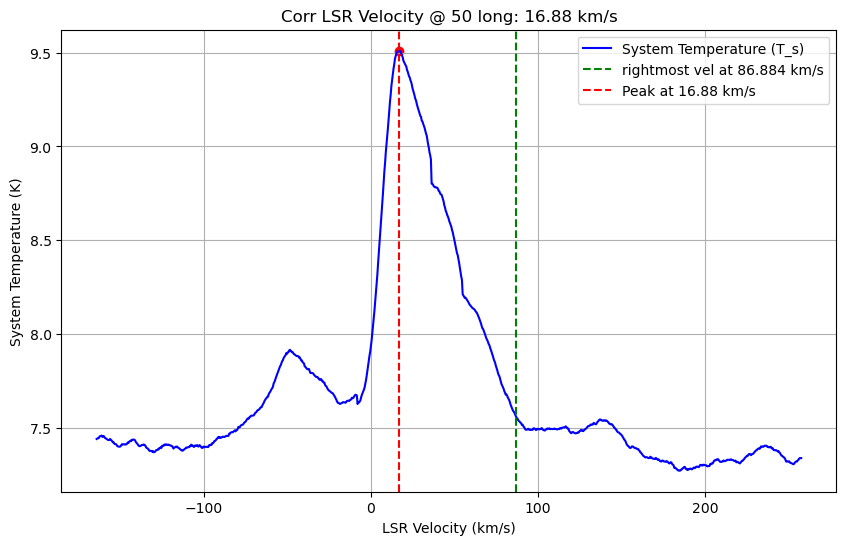

Peak System Temperature: 9.51 K at LSR Velocity: 16.88 km/s


In [76]:
#v_lsr_final = compute_lsr_velocity(azimuth, elevation, latitude, longitude, altitude, obs_time, v_obs)
#sub
#v_lsr50 = sub_lsr_velocity(93, 66, 18, 78, 474, "2025-03-12 6:44:00", v50)
v_lsr50 = v50 - v_lsr

# Unpack tuple if necessary
if isinstance(v_lsr50, tuple):
    v_lsr50 = v_lsr50[0]  # Select the first array (or second if needed)

# Ensure `v_lsr90` is an array and matches `tb90`
if len(v_lsr50) == len(tb50):
    peak_index = np.argmax(tb50)
    peak_velocity = v_lsr50[peak_index]  # No more tuple issue
    peak_temp = tb50[peak_index]
else:
    print("Mismatch in lengths! Check data shape.")

# Find the rightmost velocity using the given method
max_temp = tb50.max()  # Find maximum system temperature
max_i = list(tb50).index(max_temp)  # Find its index
v_max = v_lsr50[max_i]
ri_vel= v_max+70
print('The maximum velocity is ',ri_vel)
# Plot T_s vs. LSR Velocity
plt.figure(figsize=(10,6))
plt.plot(v_lsr50, tb50, label='System Temperature (T_s)', linestyle='solid', color='blue')
plt.title(f"right most vel @ {l1} long: {ri_vel:.2f} km/s")
plt.axvline(x=ri_vel, color='green', linestyle='dashed', label= f'rightmost vel at {ri_vel:.3f} km/s')


# Mark the peak
plt.axvline(x=peak_velocity, color='red', linestyle='dashed', label=f'Peak at {peak_velocity:.2f} km/s')
plt.scatter(peak_velocity, peak_temp, color='red', marker='o')

plt.xlabel("LSR Velocity (km/s)")
plt.ylabel("System Temperature (K)")
plt.title(f"Corr LSR Velocity @ {l1} long: {peak_velocity:.2f} km/s")
plt.legend()
plt.grid()
plt.show()

# Print peak values
print(f"Peak System Temperature: {peak_temp:.2f} K at LSR Velocity: {peak_velocity:.2f} km/s")

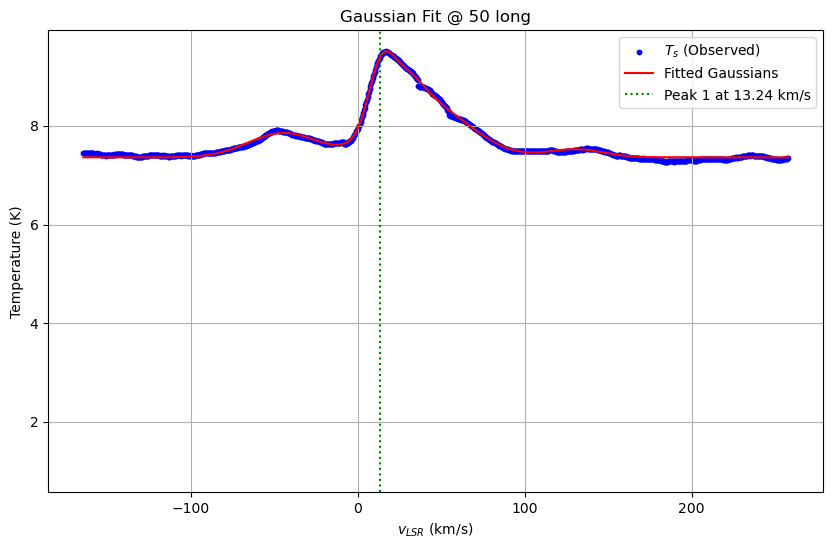

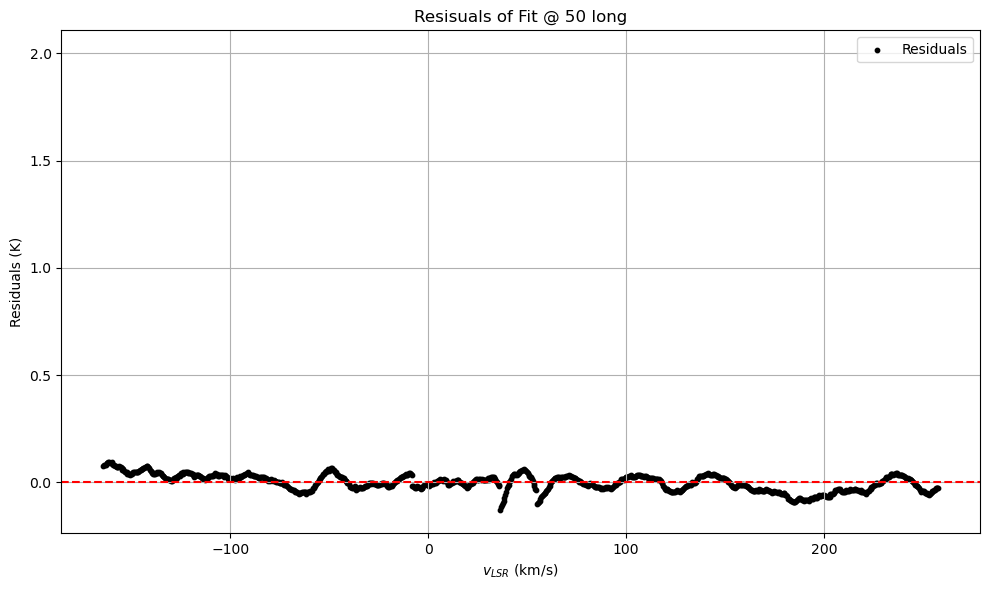

Peak 1 Velocity: 13.24 km/s


In [78]:
#sub
# Your data (Replace with actual variables)
x_data = v_lsr50  # LSR velocity
y_data = tb50          # Brightness Temperature

# Number of Gaussians to fit
n_gaussians = 5  # Adjust as needed

# Initial guesses [amp1, mean1, sigma1, shift1, amp2, mean2, sigma2, shift2, ...]
initial_guesses = [14, 17, 10, 0,  9, 40, 10, 0,  5.5, 60, 10, 0,  2.5, -50, 10, 0,  0, 110, 10, 0, ]  # Adjust manually

# Fit the data
popt = fit_gaussians(x_data, y_data, n_gaussians, initial_guesses)

# Plot results
if popt is not None:
    fitted_y = sum_of_gaussians(x_data, *popt)
    residuals = y_data - fitted_y  # Compute residuals

    plt.figure(figsize=(10, 6))

    # Plot original data and fit
    plt.plot(2, 1, 1)
    plt.scatter(x_data, y_data, s=10, label="$T_s$ (Observed)", color="blue")
    plt.plot(x_data, fitted_y, label="Fitted Gaussians", color="red")
    plt.axvline(popt[1], color='green', linestyle='dotted', label=f'Peak 1 at {popt[1]:.2f} km/s')
   # plt.axvline(popt[5], color='purple', linestyle='dotted', label=f'Peak 2 at {popt[5]:.2f} km/s')
    plt.legend()
    plt.xlabel('$v_{LSR}$ (km/s)')
    plt.ylabel('Temperature (K)')
    plt.title(f"Gaussian Fit @ {l1} long")
    plt.grid()

    # Plot residuals
    plt.figure(figsize=(10, 6))
    plt.plot(2, 1, 2)
    plt.scatter(x_data, residuals, s=10, color='black', label="Residuals")
    plt.axhline(0, color='red', linestyle='dashed')
    plt.xlabel('$v_{LSR}$ (km/s)')
    plt.ylabel('Residuals (K)')
    plt.title(f"Resisuals of Fit @ {l1} long")
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

    print(f"Peak 1 Velocity: {popt[1]:.2f} km/s")
    #print(f"Peak 2 Velocity: {popt[5]:.2f} km/s")



# 55 long

# 60 long

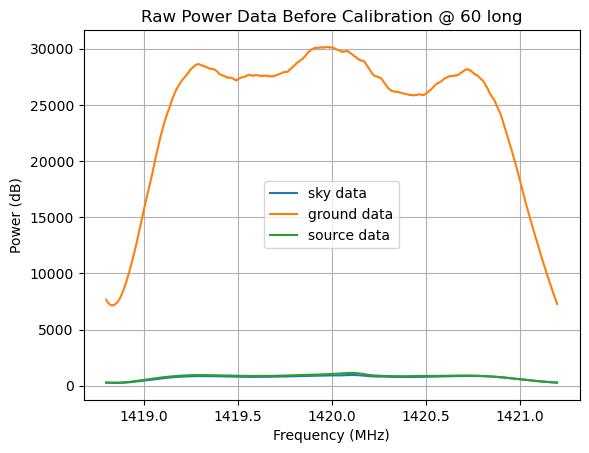

In [83]:
l1 = 60
plt.plot(f_s1, ps1, label="sky data")
plt.plot(f_g1, pg1, label="ground data")
plt.plot(f_60, p60, label="source data")
plt.legend()

plt.xlabel("Frequency (MHz)")
plt.ylabel("Power (dB)")
plt.title(f"Raw Power Data Before Calibration @ {l1} long")
plt.legend()
plt.grid()
plt.show()

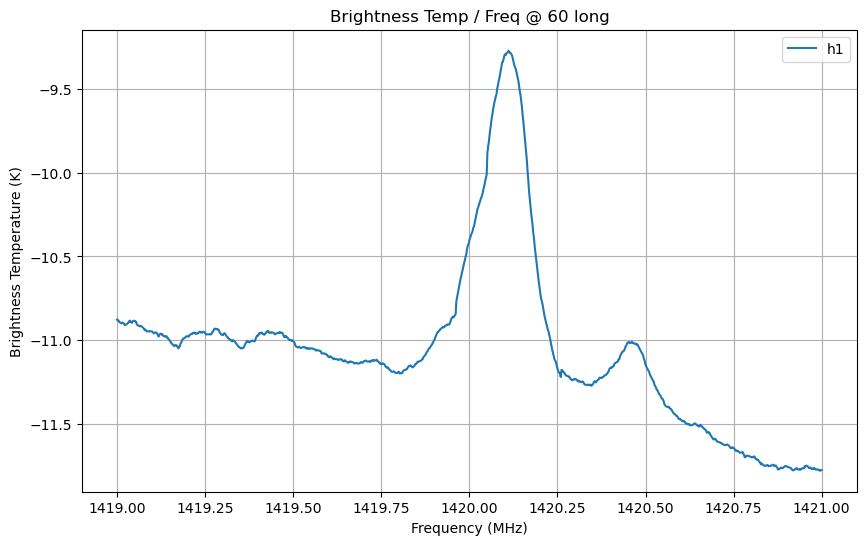

In [85]:
# Compute calibrated brightness temperature for the source
ts60 = ((T_gnd + tc) / (pg1 / p60)) - tc

t60 = ts60 - 17  # Shift values to bring them above zero

# Define frequency range to keep (adjust as needed)
freq_min = 1419.0  # MHz
freq_max = 1421.0  # MHz

# Apply mask to keep only frequencies in the selected range
mask = (f_60 >= freq_min) & (f_60 <= freq_max)

# Trim the frequency and brightness temperature data
f60 = f_60[mask]
tb60 = t60[mask]

# Plot the trimmed data
plt.figure(figsize=(10,6))
plt.plot(f60, tb60, label="h1")
plt.xlabel("Frequency (MHz)")
plt.ylabel("Brightness Temperature (K)")
plt.title(f"Brightness Temp / Freq @ {l1} long")
plt.legend()
plt.grid()
plt.show()


Peak Velocity: 62.19 km/s, Peak Temperature: -9.27 K


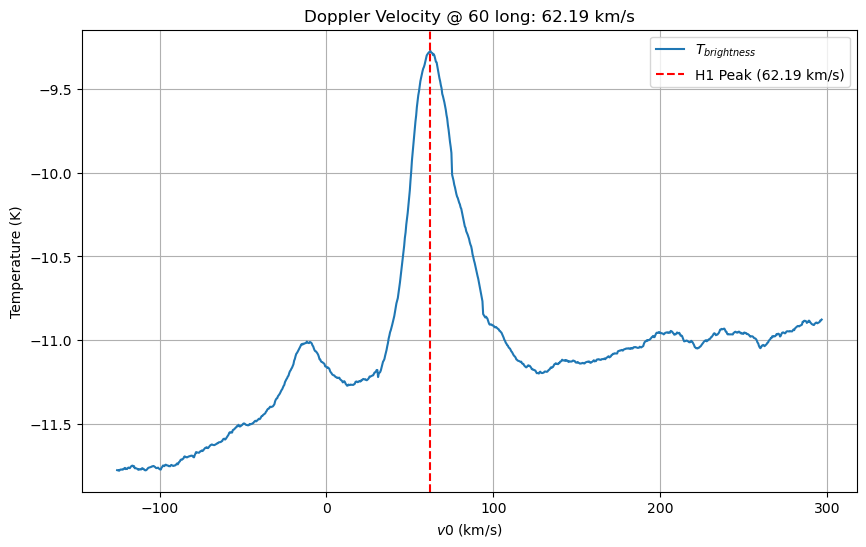

In [87]:
c = 299792.458

v60 = c* (1- f60/1420.405751768)

# Find highest peak and corresponding velocity
peak_idx = np.argmax(tb60)
peak_velocity = v60[peak_idx]
peak_temperature = tb60[peak_idx]

print(f"Peak Velocity: {peak_velocity:.2f} km/s, Peak Temperature: {peak_temperature:.2f} K")


plt.figure(figsize=(10,6))
plt.grid()
plt.plot(v60, tb60, label='$T_{brightness}$')
plt.axvline(peak_velocity, color="red", linestyle="dashed", label=f"H1 Peak ({peak_velocity:.2f} km/s)")
#plt.xticks(range(-250,250,50))
plt.title(f"Doppler Velocity @ {l1} long: {peak_velocity:.2f} km/s")
plt.xlabel('$v0$ (km/s)')
plt.ylabel('Temperature (K)')
plt.legend()
plt.show()

In [89]:
#!/usr/bin/env python
# coding: utf-8

# In[9]:

# PyAstronomy package requireq: https://pyastronomy.readthedocs.io/en/latest/index.html

from __future__ import print_function, division
from PyAstronomy import pyasl
import math
import datetime

# Coordinates of telescope
longitude = 78.2634
latitude = 18.0460
altitude = 554

# Coordinates of source (RA2000, DEC2000) RA_hr RA_min RA_sec DEC_deg DEC_min DEC_sec. Note DEC must be signed + or -.
hd1 = "19 45 23.58 +23 56 20.4"
obs_ra_2000, obs_dec_2000 = pyasl.coordsSexaToDeg(hd1)

# Time of observation converted to Julian Date
dt = datetime.datetime(2025, 3, 15, 3, 4, 00)
jd = pyasl.jdcnv(dt)

# Calculate barycentric correction (debug=True show
# various intermediate results)
corr, hjd = pyasl.helcorr(longitude, latitude, altitude, obs_ra_2000, obs_dec_2000, jd, debug=True)

#print("Barycentric correction [km/s]: ", corr)
#print("Heliocentric Julian day: ", hjd)

# Calculate LSR correction
v_sun = 20.5 # peculiar velocity (km/s) of sun w.r.t. LSR (The Solar Apex. Nature 162, 920 (1948). https://doi.org/10.1038/162920a0)
# solar apex
sun_ra = math.radians(270.2)
sun_dec = math.radians(28.7)

obs_dec = math.radians(obs_dec_2000)
obs_ra = math.radians(obs_ra_2000)

# equation from https://icts-yebes.oan.es/reports/doc/IT-CDT-2014-10.pdf
a = math.cos(sun_dec) * math.cos(obs_dec)
b = (math.cos(sun_ra) * math.cos(obs_ra)) + (math.sin(sun_ra) * math.sin(obs_ra))
c = math.sin(sun_dec) * math.sin(obs_dec)
v_rs = v_sun * ((a * b) + c)

v_lsr = corr + v_rs
print("LSR correction [km/s]: ", -v_lsr)
print("Positive value means receding (redshift) source, negative value means approaching (blueshift) source")
print("lsr: ", v_lsr)



----- HELCORR.PRO - DEBUG INFO - START ----
(obs_long (East positive),obs_lat,obs_alt) Observatory coordinates [deg,m]:  78.2634 18.046 554
(ra,dec) Object coordinates (for epoch 2000.0) [deg]:  296.34825 23.939
(ra,dec) Object coordinates (precessed to epoch 2025.291096) [deg]:  296.6162796945044 24.001786185974844
(ut) Universal time (middle of exposure) [hrs]:  3.0666666626930237
(jd) Julian date (middle of exposure) (JD):  2460749.6277777776
(hjd) Heliocentric Julian date (middle of exposure) (HJD):  2460749.625111072
(gmst) Greenwich mean sidereal time [hrs]:  14.598517982131284
(lmst) Local mean sidereal time [hrs]:  19.816077982131333
(dlat) Latitude correction [deg]:  -406.9784513200719
(lat) Geocentric latitude of observer [deg]:  17.932950430188868
(r) Distance of observer from center of earth [m]:  6376701.943730833
(v) Rotational velocity of earth at the position of the observer [km/s]:  0.4649964934974371
(vdiurnal) Projected earth rotation and earth-moon revolution [km/s

The maximum velocity is  77.25658135592985


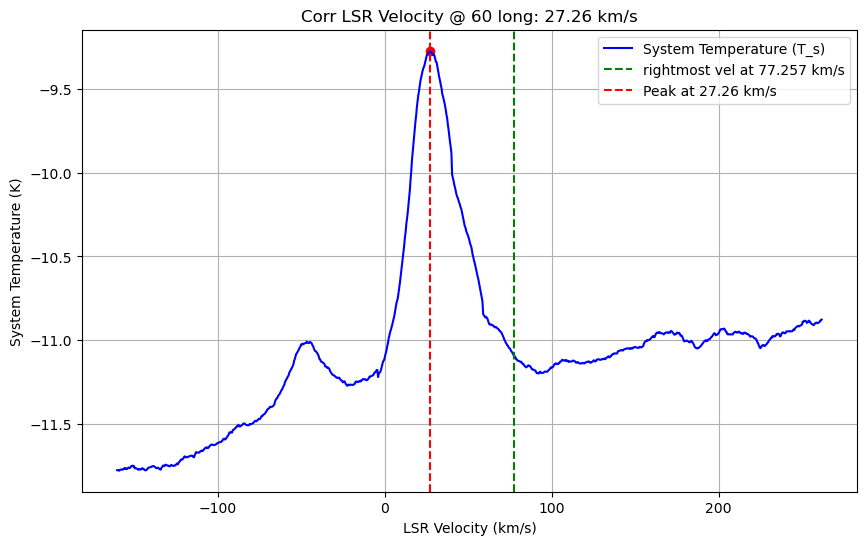

Peak System Temperature: -9.27 K at LSR Velocity: 27.26 km/s


In [91]:
#v_lsr_final = compute_lsr_velocity(azimuth, elevation, latitude, longitude, altitude, obs_time, v_obs)
#sub
#v_lsr60 = sub_lsr_velocity(308, 79, 18, 78, 474, "2025-03-12 9:18:00", v60)
v_lsr60 = v60 - v_lsr

# Unpack tuple if necessary
if isinstance(v_lsr60, tuple):
    v_lsr60 = v_lsr60[0]  # Select the first array (or second if needed)

# Ensure `v_lsr90` is an array and matches `tb90`
if len(v_lsr60) == len(tb60):
    peak_index = np.argmax(tb60)
    peak_velocity = v_lsr60[peak_index]  # No more tuple issue
    peak_temp = tb60[peak_index]
else:
    print("Mismatch in lengths! Check data shape.")

# Find the rightmost velocity using the given method
max_temp = tb60.max()  # Find maximum system temperature
max_i = list(tb60).index(max_temp)  # Find its index
v_max = v_lsr60[max_i]
ri_vel= v_max+50
print('The maximum velocity is ',ri_vel)
# Plot T_s vs. LSR Velocity
plt.figure(figsize=(10,6))
plt.plot(v_lsr60, tb60, label='System Temperature (T_s)', linestyle='solid', color='blue')
plt.title(f"right most vel @ {l1} long: {ri_vel:.2f} km/s")
plt.axvline(x=ri_vel, color='green', linestyle='dashed', label= f'rightmost vel at {ri_vel:.3f} km/s')


# Mark the peak
plt.axvline(x=peak_velocity, color='red', linestyle='dashed', label=f'Peak at {peak_velocity:.2f} km/s')
plt.scatter(peak_velocity, peak_temp, color='red', marker='o')

plt.xlabel("LSR Velocity (km/s)")
plt.ylabel("System Temperature (K)")
plt.title(f"Corr LSR Velocity @ {l1} long: {peak_velocity:.2f} km/s")
plt.legend()
plt.grid()
plt.show()

# Print peak values
print(f"Peak System Temperature: {peak_temp:.2f} K at LSR Velocity: {peak_velocity:.2f} km/s")

In [93]:
#sub
# Your data (Replace with actual variables)
x_data = v_lsr60  # LSR velocity
y_data = tb60          # Brightness Temperature

# Number of Gaussians to fit
n_gaussians = 7  # Adjust as needed

# Initial guesses [amp1, mean1, sigma1, shift1, amp2, mean2, sigma2, shift2, ...]
initial_guesses = [14, 29, 10, 0,  2, -30, 10, 0,  3, -40, 6, 0,  10, 35, 10, 0, 4, 60, 6, 0,  2, 100, 6, 0,  3, 190, 6, 0 ]  # Adjust manually

# Fit the data
popt = fit_gaussians(x_data, y_data, n_gaussians, initial_guesses)

# Plot results
if popt is not None:
    fitted_y = sum_of_gaussians(x_data, *popt)
    residuals = y_data - fitted_y  # Compute residuals

    plt.figure(figsize=(10, 6))

    # Plot original data and fit
    plt.plot(2, 1, 1)
    plt.scatter(x_data, y_data, s=10, label="$T_s$ (Observed)", color="blue")
    plt.plot(x_data, fitted_y, label="Fitted Gaussians", color="red")
    plt.axvline(popt[1], color='green', linestyle='dotted', label=f'Peak 1 at {popt[1]:.2f} km/s')
   # plt.axvline(popt[5], color='purple', linestyle='dotted', label=f'Peak 2 at {popt[5]:.2f} km/s')
    plt.legend()
    plt.xlabel('$v_{LSR}$ (km/s)')
    plt.ylabel('Temperature (K)')
    plt.title(f"Gaussian Fit @ {l1} long")
    plt.grid()

    # Plot residuals
    plt.figure(figsize=(10, 6))
    plt.plot(2, 1, 2)
    plt.scatter(x_data, residuals, s=10, color='black', label="Residuals")
    plt.axhline(0, color='red', linestyle='dashed')
    plt.xlabel('$v_{LSR}$ (km/s)')
    plt.ylabel('Residuals (K)')
    plt.title(f"Resisuals of Fit @ {l1} long")
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

    print(f"Peak 1 Velocity: {popt[1]:.2f} km/s")
    #print(f"Peak 2 Velocity: {popt[5]:.2f} km/s")



Fitting failed: Optimal parameters not found: Number of calls to function has reached maxfev = 5800.


# 65 long

# 70 long

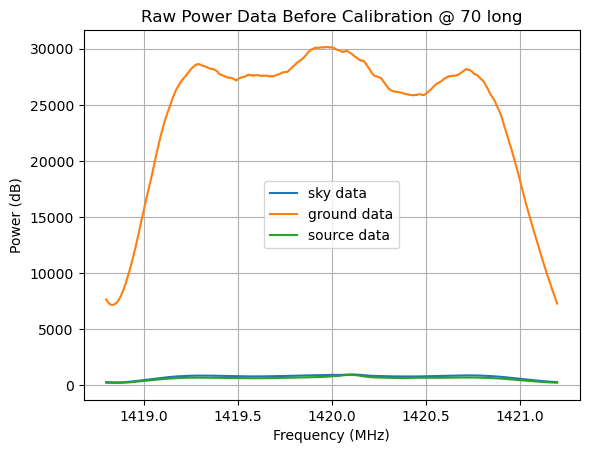

In [99]:
l1 = 70
plt.plot(f_s1, ps1, label="sky data")
plt.plot(f_g1, pg1, label="ground data")
plt.plot(f_70, p70, label="source data")
plt.legend()

plt.xlabel("Frequency (MHz)")
plt.ylabel("Power (dB)")
plt.title(f"Raw Power Data Before Calibration @ {l1} long")
plt.legend()
plt.grid()
plt.show()

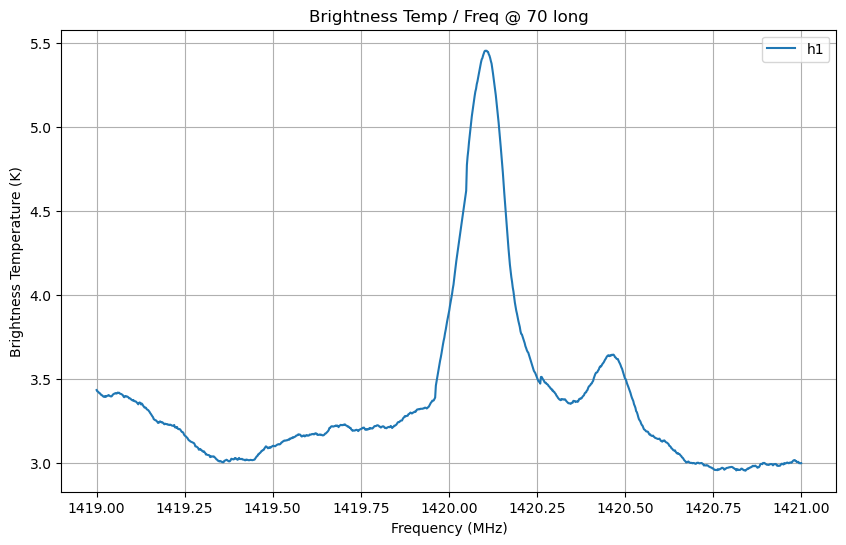

In [103]:
# Compute calibrated brightness temperature for the source
ts70 = ((T_gnd + tc) / (pg1 / p70)) - tc

t70 = ts70 - 0  # Shift values to bring them above zero

# Define frequency range to keep (adjust as needed)
freq_min = 1419.0  # MHz
freq_max = 1421.0  # MHz

# Apply mask to keep only frequencies in the selected range
mask = (f_70 >= freq_min) & (f_70 <= freq_max)

# Trim the frequency and brightness temperature data
f70 = f_70[mask]
tb70 = t70[mask]

# Plot the trimmed data
plt.figure(figsize=(10,6))
plt.plot(f70, tb70, label="h1")
plt.xlabel("Frequency (MHz)")
plt.ylabel("Brightness Temperature (K)")
plt.title(f"Brightness Temp / Freq @ {l1} long")
plt.legend()
plt.grid()
plt.show()


Peak Velocity: 63.88 km/s, Peak Temperature: 5.45 K


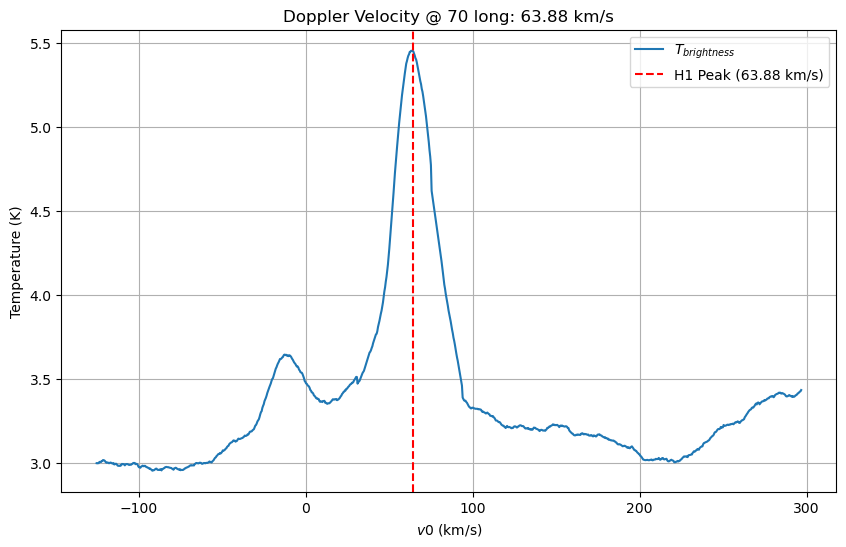

In [105]:
c = 299792.458

v70 = c* (1- f70/1420.405751768)

# Find highest peak and corresponding velocity
peak_idx = np.argmax(tb70)
peak_velocity = v70[peak_idx]
peak_temperature = tb70[peak_idx]

print(f"Peak Velocity: {peak_velocity:.2f} km/s, Peak Temperature: {peak_temperature:.2f} K")


plt.figure(figsize=(10,6))
plt.grid()
plt.plot(v70, tb70, label='$T_{brightness}$')
plt.axvline(peak_velocity, color="red", linestyle="dashed", label=f"H1 Peak ({peak_velocity:.2f} km/s)")
#plt.xticks(range(-250,250,50))
plt.title(f"Doppler Velocity @ {l1} long: {peak_velocity:.2f} km/s")
plt.xlabel('$v0$ (km/s)')
plt.ylabel('Temperature (K)')
plt.legend()
plt.show()

In [107]:
#!/usr/bin/env python
# coding: utf-8

# In[9]:

# PyAstronomy package requireq: https://pyastronomy.readthedocs.io/en/latest/index.html

from __future__ import print_function, division
from PyAstronomy import pyasl
import math
import datetime

# Coordinates of telescope
longitude = 78.2634
latitude = 18.0460
altitude = 554

# Coordinates of source (RA2000, DEC2000) RA_hr RA_min RA_sec DEC_deg DEC_min DEC_sec. Note DEC must be signed + or -.
hd1 = "20 7 56.99 +32 34 56.0"
obs_ra_2000, obs_dec_2000 = pyasl.coordsSexaToDeg(hd1)

# Time of observation converted to Julian Date
dt = datetime.datetime(2025, 3, 15, 3, 7, 00)
jd = pyasl.jdcnv(dt)

# Calculate barycentric correction (debug=True show
# various intermediate results)
corr, hjd = pyasl.helcorr(longitude, latitude, altitude, obs_ra_2000, obs_dec_2000, jd, debug=True)

#print("Barycentric correction [km/s]: ", corr)
#print("Heliocentric Julian day: ", hjd)

# Calculate LSR correction
v_sun = 20.5 # peculiar velocity (km/s) of sun w.r.t. LSR (The Solar Apex. Nature 162, 920 (1948). https://doi.org/10.1038/162920a0)
# solar apex
sun_ra = math.radians(270.2)
sun_dec = math.radians(28.7)

obs_dec = math.radians(obs_dec_2000)
obs_ra = math.radians(obs_ra_2000)

# equation from https://icts-yebes.oan.es/reports/doc/IT-CDT-2014-10.pdf
a = math.cos(sun_dec) * math.cos(obs_dec)
b = (math.cos(sun_ra) * math.cos(obs_ra)) + (math.sin(sun_ra) * math.sin(obs_ra))
c = math.sin(sun_dec) * math.sin(obs_dec)
v_rs = v_sun * ((a * b) + c)

v_lsr = corr + v_rs
print("LSR correction [km/s]: ", -v_lsr)
print("Positive value means receding (redshift) source, negative value means approaching (blueshift) source")
print("lsr: ", v_lsr)



----- HELCORR.PRO - DEBUG INFO - START ----
(obs_long (East positive),obs_lat,obs_alt) Observatory coordinates [deg,m]:  78.2634 18.046 554
(ra,dec) Object coordinates (for epoch 2000.0) [deg]:  301.98745833333334 32.58222222222223
(ra,dec) Object coordinates (precessed to epoch 2025.291096) [deg]:  302.2351927452262 32.657067370327844
(ut) Universal time (middle of exposure) [hrs]:  3.1166666708886623
(jd) Julian date (middle of exposure) (JD):  2460749.6298611113
(hjd) Heliocentric Julian date (middle of exposure) (HJD):  2460749.62704979
(gmst) Greenwich mean sidereal time [hrs]:  14.648654885817677
(lmst) Local mean sidereal time [hrs]:  19.866214885817726
(dlat) Latitude correction [deg]:  -406.9784513200719
(lat) Geocentric latitude of observer [deg]:  17.932950430188868
(r) Distance of observer from center of earth [m]:  6376701.943730833
(v) Rotational velocity of earth at the position of the observer [km/s]:  0.4649964934974371
(vdiurnal) Projected earth rotation and earth-mo

The maximum velocity is  58.03709927310611


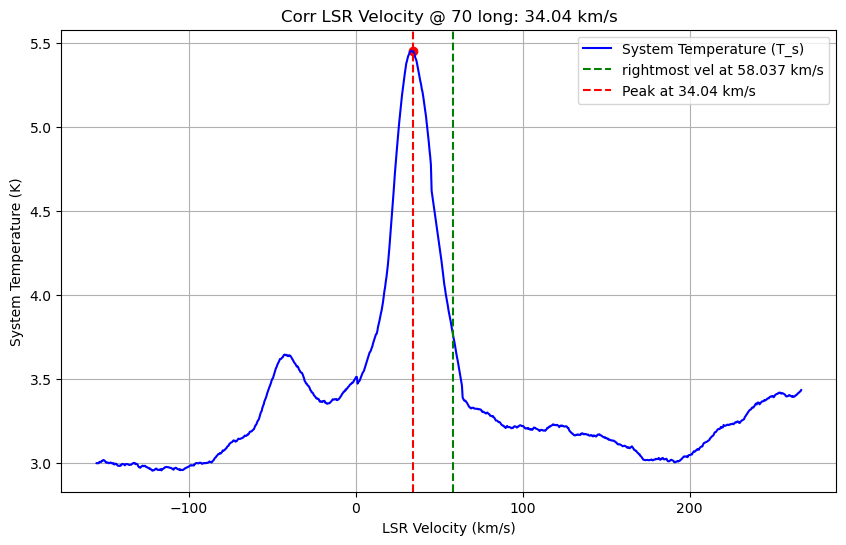

Peak System Temperature: 5.45 K at LSR Velocity: 34.04 km/s


In [109]:
#v_lsr_final = compute_lsr_velocity(azimuth, elevation, latitude, longitude, altitude, obs_time, v_obs)
#sub
#v_lsr70 = sub_lsr_velocity(346, 74, 18, 78, 474, "2025-03-12 9:24:00", v70)
v_lsr70 = v70 - v_lsr

# Unpack tuple if necessary
if isinstance(v_lsr70, tuple):
    v_lsr70 = v_lsr70[0]  # Select the first array (or second if needed)

# Ensure `v_lsr90` is an array and matches `tb90`
if len(v_lsr70) == len(tb70):
    peak_index = np.argmax(tb70)
    peak_velocity = v_lsr70[peak_index]  # No more tuple issue
    peak_temp = tb70[peak_index]
else:
    print("Mismatch in lengths! Check data shape.")

# Find the rightmost velocity using the given method
max_temp = tb70.max()  # Find maximum system temperature
max_i = list(tb70).index(max_temp)  # Find its index
v_max = v_lsr70[max_i]
ri_vel= v_max+24
print('The maximum velocity is ',ri_vel)
# Plot T_s vs. LSR Velocity
plt.figure(figsize=(10,6))
plt.plot(v_lsr70, tb70, label='System Temperature (T_s)', linestyle='solid', color='blue')
plt.title(f"right most vel @ {l1} long: {ri_vel:.2f} km/s")
plt.axvline(x=ri_vel, color='green', linestyle='dashed', label= f'rightmost vel at {ri_vel:.3f} km/s')


# Mark the peak
plt.axvline(x=peak_velocity, color='red', linestyle='dashed', label=f'Peak at {peak_velocity:.2f} km/s')
plt.scatter(peak_velocity, peak_temp, color='red', marker='o')

plt.xlabel("LSR Velocity (km/s)")
plt.ylabel("System Temperature (K)")
plt.title(f"Corr LSR Velocity @ {l1} long: {peak_velocity:.2f} km/s")
plt.legend()
plt.grid()
plt.show()

# Print peak values
print(f"Peak System Temperature: {peak_temp:.2f} K at LSR Velocity: {peak_velocity:.2f} km/s")

In [111]:
#sub
# Your data (Replace with actual variables)
x_data = v_lsr70  # LSR velocity
y_data = tb70          # Brightness Temperature

# Number of Gaussians to fit
n_gaussians = 7  # Adjust as needed

# Initial guesses [amp1, mean1, sigma1, shift1, amp2, mean2, sigma2, shift2, ...]
initial_guesses = [14, 36, 10, 0,  2, -30, 10, 0,  3, -40, 6, 0,  10, 35, 10, 0, 4, 60, 6, 0,  2, 100, 6, 0,  3, 190, 6, 0 ]  # Adjust manually

# Fit the data
popt = fit_gaussians(x_data, y_data, n_gaussians, initial_guesses)

# Plot results
if popt is not None:
    fitted_y = sum_of_gaussians(x_data, *popt)
    residuals = y_data - fitted_y  # Compute residuals

    plt.figure(figsize=(10, 6))

    # Plot original data and fit
    plt.plot(2, 1, 1)
    plt.scatter(x_data, y_data, s=10, label="$T_s$ (Observed)", color="blue")
    plt.plot(x_data, fitted_y, label="Fitted Gaussians", color="red")
    plt.axvline(popt[1], color='green', linestyle='dotted', label=f'Peak 1 at {popt[1]:.2f} km/s')
   # plt.axvline(popt[5], color='purple', linestyle='dotted', label=f'Peak 2 at {popt[5]:.2f} km/s')
    plt.legend()
    plt.xlabel('$v_{LSR}$ (km/s)')
    plt.ylabel('Temperature (K)')
    plt.title(f"Gaussian Fit @ {l1} long")
    plt.grid()

    # Plot residuals
    plt.figure(figsize=(10, 6))
    plt.plot(2, 1, 2)
    plt.scatter(x_data, residuals, s=10, color='black', label="Residuals")
    plt.axhline(0, color='red', linestyle='dashed')
    plt.xlabel('$v_{LSR}$ (km/s)')
    plt.ylabel('Residuals (K)')
    plt.title(f"Resisuals of Fit @ {l1} long")
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

    print(f"Peak 1 Velocity: {popt[1]:.2f} km/s")
    #print(f"Peak 2 Velocity: {popt[5]:.2f} km/s")



Fitting failed: Optimal parameters not found: Number of calls to function has reached maxfev = 5800.


# 75 long

# 80 long

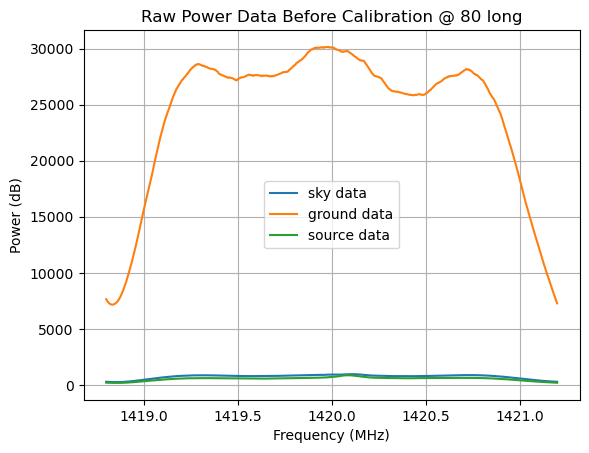

In [117]:
l1 = 80
plt.plot(f_s1, ps1, label="sky data")
plt.plot(f_g1, pg1, label="ground data")
plt.plot(f_80, p80, label="source data")
plt.legend()

plt.xlabel("Frequency (MHz)")
plt.ylabel("Power (dB)")
plt.title(f"Raw Power Data Before Calibration @ {l1} long")
plt.legend()
plt.grid()
plt.show()

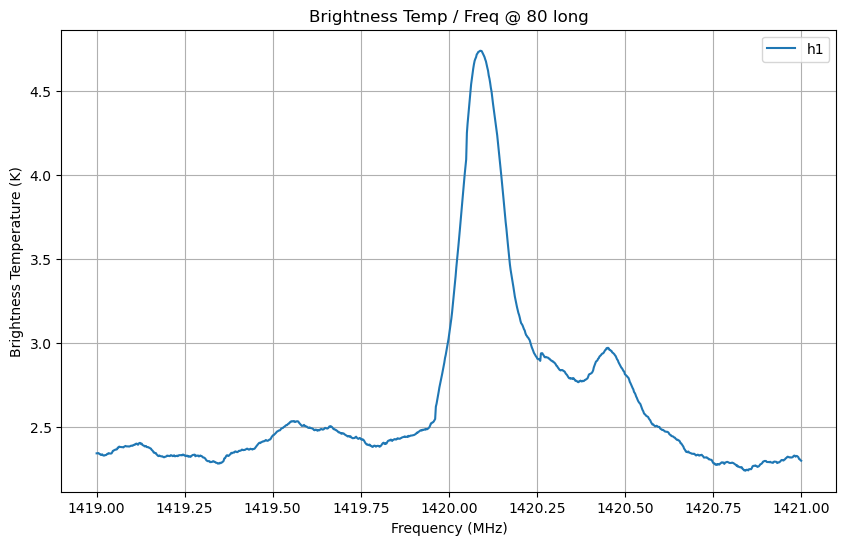

In [121]:
# Compute calibrated brightness temperature for the source
ts80 = ((T_gnd + tc) / (pg1 / p80)) - tc

t80 = ts80 - 0  # Shift values to bring them above zero

# Define frequency range to keep (adjust as needed)
freq_min = 1419.0  # MHz
freq_max = 1421.0  # MHz

# Apply mask to keep only frequencies in the selected range
mask = (f_80 >= freq_min) & (f_80 <= freq_max)

# Trim the frequency and brightness temperature data
f80 = f_80[mask]
tb80 = t80[mask]

# Plot the trimmed data
plt.figure(figsize=(10,6))
plt.plot(f80, tb80, label="h1")
plt.xlabel("Frequency (MHz)")
plt.ylabel("Brightness Temperature (K)")
plt.title(f"Brightness Temp / Freq @ {l1} long")
plt.legend()
plt.grid()
plt.show()


Peak Velocity: 66.84 km/s, Peak Temperature: 4.74 K


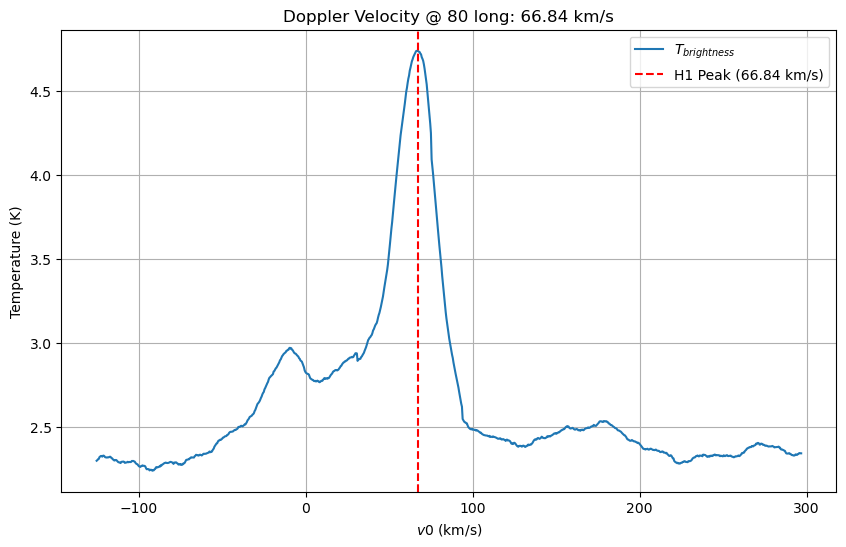

In [123]:
c = 299792.458

v80 = c* (1- f80/1420.405751768)

# Find highest peak and corresponding velocity
peak_idx = np.argmax(tb80)
peak_velocity = v80[peak_idx]
peak_temperature = tb80[peak_idx]

print(f"Peak Velocity: {peak_velocity:.2f} km/s, Peak Temperature: {peak_temperature:.2f} K")


plt.figure(figsize=(10,6))
plt.grid()
plt.plot(v80, tb80, label='$T_{brightness}$')
plt.axvline(peak_velocity, color="red", linestyle="dashed", label=f"H1 Peak ({peak_velocity:.2f} km/s)")
#plt.xticks(range(-250,250,50))
plt.title(f"Doppler Velocity @ {l1} long: {peak_velocity:.2f} km/s")
plt.xlabel('$v0$ (km/s)')
plt.ylabel('Temperature (K)')
plt.legend()
plt.show()

In [125]:
#!/usr/bin/env python
# coding: utf-8

# In[9]:

# PyAstronomy package requireq: https://pyastronomy.readthedocs.io/en/latest/index.html

from __future__ import print_function, division
from PyAstronomy import pyasl
import math
import datetime

# Coordinates of telescope
longitude = 78.2634
latitude = 18.0460
altitude = 554

# Coordinates of source (RA2000, DEC2000) RA_hr RA_min RA_sec DEC_deg DEC_min DEC_sec. Note DEC must be signed + or -.
hd1 = "20 36 34.48 +40 28 30.4"
obs_ra_2000, obs_dec_2000 = pyasl.coordsSexaToDeg(hd1)

# Time of observation converted to Julian Date
dt = datetime.datetime(2025, 3, 15, 3, 10, 00)
jd = pyasl.jdcnv(dt)

# Calculate barycentric correction (debug=True show
# various intermediate results)
corr, hjd = pyasl.helcorr(longitude, latitude, altitude, obs_ra_2000, obs_dec_2000, jd, debug=True)

#print("Barycentric correction [km/s]: ", corr)
#print("Heliocentric Julian day: ", hjd)

# Calculate LSR correction
v_sun = 20.5 # peculiar velocity (km/s) of sun w.r.t. LSR (The Solar Apex. Nature 162, 920 (1948). https://doi.org/10.1038/162920a0)
# solar apex
sun_ra = math.radians(270.2)
sun_dec = math.radians(28.7)

obs_dec = math.radians(obs_dec_2000)
obs_ra = math.radians(obs_ra_2000)

# equation from https://icts-yebes.oan.es/reports/doc/IT-CDT-2014-10.pdf
a = math.cos(sun_dec) * math.cos(obs_dec)
b = (math.cos(sun_ra) * math.cos(obs_ra)) + (math.sin(sun_ra) * math.sin(obs_ra))
c = math.sin(sun_dec) * math.sin(obs_dec)
v_rs = v_sun * ((a * b) + c)

v_lsr = corr + v_rs
print("LSR correction [km/s]: ", -v_lsr)
print("Positive value means receding (redshift) source, negative value means approaching (blueshift) source")
print("lsr: ", v_lsr)



----- HELCORR.PRO - DEBUG INFO - START ----
(obs_long (East positive),obs_lat,obs_alt) Observatory coordinates [deg,m]:  78.2634 18.046 554
(ra,dec) Object coordinates (for epoch 2000.0) [deg]:  309.14366666666666 40.47511111111111
(ra,dec) Object coordinates (precessed to epoch 2025.291096) [deg]:  309.374551610866 40.56421414061528
(ut) Universal time (middle of exposure) [hrs]:  3.16666666790843
(jd) Julian date (middle of exposure) (JD):  2460749.6319444445
(hjd) Heliocentric Julian date (middle of exposure) (HJD):  2460749.629033616
(gmst) Greenwich mean sidereal time [hrs]:  14.698791778297505
(lmst) Local mean sidereal time [hrs]:  19.916351778297553
(dlat) Latitude correction [deg]:  -406.9784513200719
(lat) Geocentric latitude of observer [deg]:  17.932950430188868
(r) Distance of observer from center of earth [m]:  6376701.943730833
(v) Rotational velocity of earth at the position of the observer [km/s]:  0.4649964934974371
(vdiurnal) Projected earth rotation and earth-moon 

The maximum velocity is  58.93806292259792


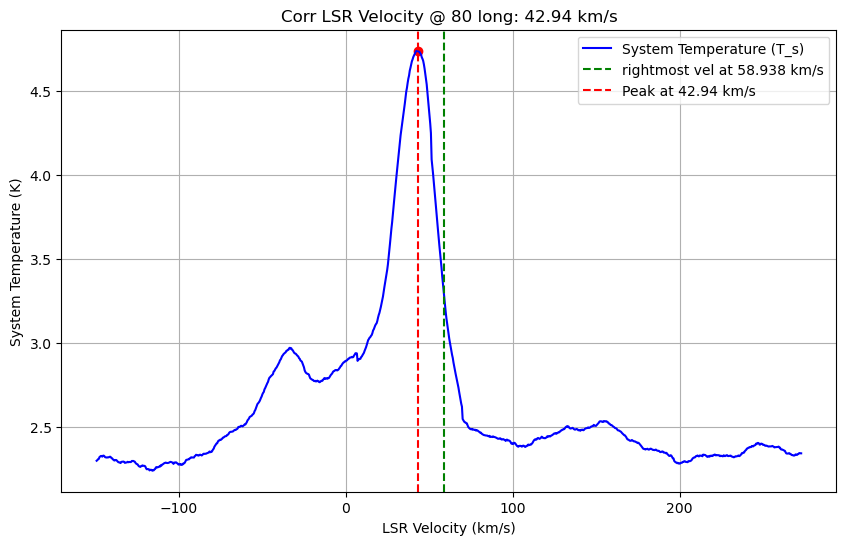

Peak System Temperature: 4.74 K at LSR Velocity: 42.94 km/s


In [127]:
#v_lsr_final = compute_lsr_velocity(azimuth, elevation, latitude, longitude, altitude, obs_time, v_obs)
#sub
#v_lsr80 = sub_lsr_velocity(3, 67, 18, 78, 474, "2025-03-12 9:29:00", v80)
v_lsr80 = v80 - v_lsr

# Unpack tuple if necessar8
if isinstance(v_lsr80, tuple):
    v_lsr80 = v_lsr80[0]  # Select the first array (or second if needed)

# Ensure `v_lsr90` is an array and matches `tb90`
if len(v_lsr80) == len(tb80):
    peak_index = np.argmax(tb80)
    peak_velocity = v_lsr80[peak_index]  # No more tuple issue
    peak_temp = tb80[peak_index]
else:
    print("Mismatch in lengths! Check data shape.")

# Find the rightmost velocity using the given method
max_temp = tb80.max()  # Find maximum system temperature
max_i = list(tb80).index(max_temp)  # Find its index
v_max = v_lsr80[max_i]
ri_vel= v_max+16
print('The maximum velocity is ',ri_vel)
# Plot T_s vs. LSR Velocity
plt.figure(figsize=(10,6))
plt.plot(v_lsr80, tb80, label='System Temperature (T_s)', linestyle='solid', color='blue')
plt.title(f"right most vel @ {l1} long: {ri_vel:.2f} km/s")
plt.axvline(x=ri_vel, color='green', linestyle='dashed', label= f'rightmost vel at {ri_vel:.3f} km/s')


# Mark the peak
plt.axvline(x=peak_velocity, color='red', linestyle='dashed', label=f'Peak at {peak_velocity:.2f} km/s')
plt.scatter(peak_velocity, peak_temp, color='red', marker='o')

plt.xlabel("LSR Velocity (km/s)")
plt.ylabel("System Temperature (K)")
plt.title(f"Corr LSR Velocity @ {l1} long: {peak_velocity:.2f} km/s")
plt.legend()
plt.grid()
plt.show()

# Print peak values
print(f"Peak System Temperature: {peak_temp:.2f} K at LSR Velocity: {peak_velocity:.2f} km/s")

In [129]:
#sub
# Your data (Replace with actual variables)
x_data = v_lsr80  # LSR velocity
y_data = tb80          # Brightness Temperature

# Number of Gaussians to fit
n_gaussians = 7  # Adjust as needed

# Initial guesses [amp1, mean1, sigma1, shift1, amp2, mean2, sigma2, shift2, ...]
initial_guesses = [15, 45, 10, 0,  2, -30, 10, 0,  3, -40, 6, 0,  10, 35, 10, 0, 4, 60, 6, 0,  2, 100, 6, 0,  3, 190, 6, 0 ]  # Adjust manually

# Fit the data
popt = fit_gaussians(x_data, y_data, n_gaussians, initial_guesses)

# Plot results
if popt is not None:
    fitted_y = sum_of_gaussians(x_data, *popt)
    residuals = y_data - fitted_y  # Compute residuals

    plt.figure(figsize=(10, 6))

    # Plot original data and fit
    plt.plot(2, 1, 1)
    plt.scatter(x_data, y_data, s=10, label="$T_s$ (Observed)", color="blue")
    plt.plot(x_data, fitted_y, label="Fitted Gaussians", color="red")
    plt.axvline(popt[1], color='green', linestyle='dotted', label=f'Peak 1 at {popt[1]:.2f} km/s')
   # plt.axvline(popt[5], color='purple', linestyle='dotted', label=f'Peak 2 at {popt[5]:.2f} km/s')
    plt.legend()
    plt.xlabel('$v_{LSR}$ (km/s)')
    plt.ylabel('Temperature (K)')
    plt.title(f"Gaussian Fit @ {l1} long")
    plt.grid()

    # Plot residuals
    plt.figure(figsize=(10, 6))
    plt.plot(2, 1, 2)
    plt.scatter(x_data, residuals, s=10, color='black', label="Residuals")
    plt.axhline(0, color='red', linestyle='dashed')
    plt.xlabel('$v_{LSR}$ (km/s)')
    plt.ylabel('Residuals (K)')
    plt.title(f"Resisuals of Fit @ {l1} long")
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

    print(f"Peak 1 Velocity: {popt[1]:.2f} km/s")
    #print(f"Peak 2 Velocity: {popt[5]:.2f} km/s")



Fitting failed: Optimal parameters not found: Number of calls to function has reached maxfev = 5800.


# 85 long

# 90 long

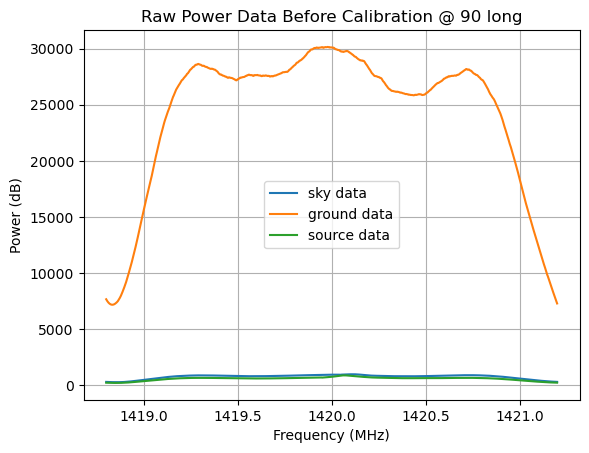

In [135]:
l1 = 90
plt.plot(f_s1, ps1, label="sky data")
plt.plot(f_g1, pg1, label="ground data")
plt.plot(f_90, p90, label="source data")
plt.legend()

plt.xlabel("Frequency (MHz)")
plt.ylabel("Power (dB)")
plt.title(f"Raw Power Data Before Calibration @ {l1} long")
plt.legend()
plt.grid()
plt.show()

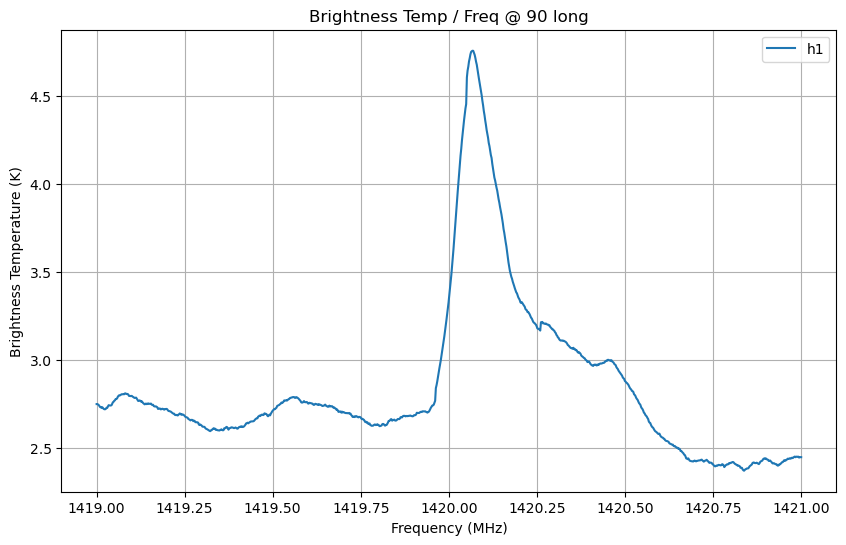

In [139]:
# Compute calibrated brightness temperature for the source
ts90 = ((T_gnd + tc) / (pg1 / p90)) - tc

t90 = ts90 - 0  # Shift values to bring them above zero

# Define frequency range to keep (adjust as needed)
freq_min = 1419.0  # MHz
freq_max = 1421.0  # MHz

# Apply mask to keep only frequencies in the selected range
mask = (f_90 >= freq_min) & (f_90 <= freq_max)

# Trim the frequency and brightness temperature data
f90 = f_90[mask]
tb90 = t90[mask]

# Plot the trimmed data
plt.figure(figsize=(10,6))
plt.plot(f90, tb90, label="h1")
plt.xlabel("Frequency (MHz)")
plt.ylabel("Brightness Temperature (K)")
plt.title(f"Brightness Temp / Freq @ {l1} long")
plt.legend()
plt.grid()
plt.show()


Peak Velocity: 71.49 km/s, Peak Temperature: 4.76 K


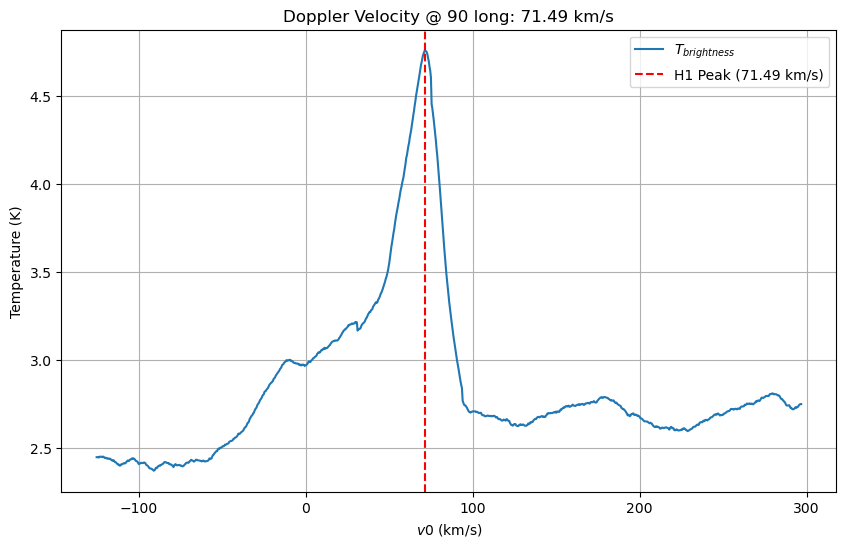

In [141]:
c = 299792.458

v90 = c* ((1420.405751768- f90)/1420.405751768)

# Find highest peak and corresponding velocity
peak_idx = np.argmax(tb90)
peak_velocity = v90[peak_idx]
peak_temperature = tb90[peak_idx]

print(f"Peak Velocity: {peak_velocity:.2f} km/s, Peak Temperature: {peak_temperature:.2f} K")


plt.figure(figsize=(10,6))
plt.grid()
plt.plot(v90, tb90, label='$T_{brightness}$')
plt.axvline(peak_velocity, color="red", linestyle="dashed", label=f"H1 Peak ({peak_velocity:.2f} km/s)")
#plt.xticks(range(-250,250,50))
plt.title(f"Doppler Velocity @ {l1} long: {peak_velocity:.2f} km/s")
plt.xlabel('$v0$ (km/s)')
plt.ylabel('Temperature (K)')
plt.legend()
plt.show()

In [143]:
#!/usr/bin/env python
# coding: utf-8

# In[9]:

# PyAstronomy package requireq: https://pyastronomy.readthedocs.io/en/latest/index.html

from __future__ import print_function, division
from PyAstronomy import pyasl
import math
import datetime

# Coordinates of telescope
longitude = 78.2634
latitude = 18.0460
altitude = 554

# Coordinates of source (RA2000, DEC2000) RA_hr RA_min RA_sec DEC_deg DEC_min DEC_sec. Note DEC must be signed + or -.
hd1 = "21 12 46.39 +48 35 20.6"
obs_ra_2000, obs_dec_2000 = pyasl.coordsSexaToDeg(hd1)

# Time of observation converted to Julian Date
dt = datetime.datetime(2025, 3, 15, 3, 13, 00)
jd = pyasl.jdcnv(dt)

# Calculate barycentric correction (debug=True show
# various intermediate results)
corr, hjd = pyasl.helcorr(longitude, latitude, altitude, obs_ra_2000, obs_dec_2000, jd, debug=True)

#print("Barycentric correction [km/s]: ", corr)
#print("Heliocentric Julian day: ", hjd)

# Calculate LSR correction
v_sun = 20.5 # peculiar velocity (km/s) of sun w.r.t. LSR (The Solar Apex. Nature 162, 920 (1948). https://doi.org/10.1038/162920a0)
# solar apex
sun_ra = math.radians(270.2)
sun_dec = math.radians(28.7)

obs_dec = math.radians(obs_dec_2000)
obs_ra = math.radians(obs_ra_2000)

# equation from https://icts-yebes.oan.es/reports/doc/IT-CDT-2014-10.pdf
a = math.cos(sun_dec) * math.cos(obs_dec)
b = (math.cos(sun_ra) * math.cos(obs_ra)) + (math.sin(sun_ra) * math.sin(obs_ra))
c = math.sin(sun_dec) * math.sin(obs_dec)
v_rs = v_sun * ((a * b) + c)

v_lsr = corr + v_rs
print("LSR correction [km/s]: ", -v_lsr)
print("Positive value means receding (redshift) source, negative value means approaching (blueshift) source")
print("lsr: ", v_lsr)



----- HELCORR.PRO - DEBUG INFO - START ----
(obs_long (East positive),obs_lat,obs_alt) Observatory coordinates [deg,m]:  78.2634 18.046 554
(ra,dec) Object coordinates (for epoch 2000.0) [deg]:  318.19329166666665 48.58905555555556
(ra,dec) Object coordinates (precessed to epoch 2025.291096) [deg]:  318.4109606343869 48.69418662071965
(ut) Universal time (middle of exposure) [hrs]:  3.216666664928198
(jd) Julian date (middle of exposure) (JD):  2460749.6340277777
(hjd) Heliocentric Julian date (middle of exposure) (HJD):  2460749.6311481493
(gmst) Greenwich mean sidereal time [hrs]:  14.748928670777445
(lmst) Local mean sidereal time [hrs]:  19.966488670777494
(dlat) Latitude correction [deg]:  -406.9784513200719
(lat) Geocentric latitude of observer [deg]:  17.932950430188868
(r) Distance of observer from center of earth [m]:  6376701.943730833
(v) Rotational velocity of earth at the position of the observer [km/s]:  0.4649964934974371
(vdiurnal) Projected earth rotation and earth-mo

The maximum velocity is  72.54277608577979


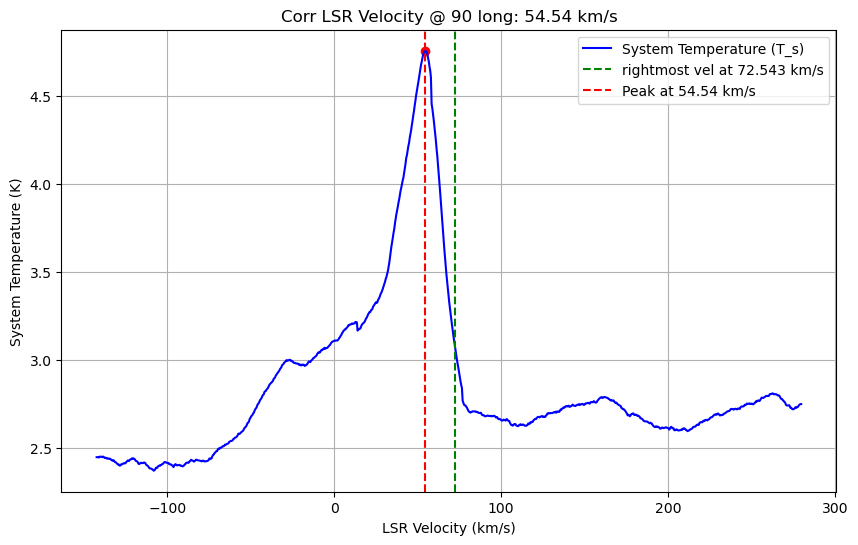

Peak System Temperature: 4.76 K at LSR Velocity: 54.54 km/s


In [145]:
#v_lsr_final = compute_lsr_velocity(azimuth, elevation, latitude, longitude, altitude, obs_time, v_obs)
#sub
#v_lsr90 = sub_lsr_velocity(12, 58, 18.0460, 78.2634, 474, "2025-03-12 09:34:00", v90)
#print(type(v_lsr90), v_lsr90)
v_lsr90 = v90 - v_lsr

# Unpack tuple if necessary
if isinstance(v_lsr90, tuple):
    v_lsr90 = v_lsr90[0]  # Select the first array (or second if needed)

# Ensure `v_lsr90` is an array and matches `tb90`
if len(v_lsr90) == len(tb90):
    peak_index = np.argmax(tb90)
    peak_velocity = v_lsr90[peak_index]  # No more tuple issue
    peak_temp = tb90[peak_index]
else:
    print("Mismatch in lengths! Check data shape.")


# Find the rightmost velocity using the given method
max_temp = tb90.max()  # Find maximum system temperature
max_i = list(tb90).index(max_temp)  # Find its index
v_max = v_lsr90[max_i]
ri_vel= v_max+18
print('The maximum velocity is ',ri_vel)
# Plot T_s vs. LSR Velocity
plt.figure(figsize=(10,6))
plt.plot(v_lsr90, tb90, label='System Temperature (T_s)', linestyle='solid', color='blue')
plt.title(f"right most vel @ {l1} long: {ri_vel:.2f} km/s")
plt.axvline(x=ri_vel, color='green', linestyle='dashed', label= f'rightmost vel at {ri_vel:.3f} km/s')


# Mark the peak
plt.axvline(x=peak_velocity, color='red', linestyle='dashed', label=f'Peak at {peak_velocity:.2f} km/s')
plt.scatter(peak_velocity, peak_temp, color='red', marker='o')

plt.xlabel("LSR Velocity (km/s)")
plt.ylabel("System Temperature (K)")
plt.title(f"Corr LSR Velocity @ {l1} long: {peak_velocity:.2f} km/s")
plt.legend()
plt.grid()
plt.show()

# Print peak values
print(f"Peak System Temperature: {peak_temp:.2f} K at LSR Velocity: {peak_velocity:.2f} km/s")

In [3736]:
#sub
# Your data (Replace with actual variables)
x_data = v_lsr90  # LSR velocity
y_data = tb90          # Brightness Temperature

# Number of Gaussians to fit
n_gaussians = 7  # Adjust as needed

# Initial guesses [amp1, mean1, sigma1, shift1, amp2, mean2, sigma2, shift2, ...]
initial_guesses = [15, 56, 10, 0,  2, 0, 10, 0,  3, -40, 6, 0,  10, 35, 6, 0, 4, 60, 6, 0,  2, 100, 6, 0,  3, 190, 10, 0 ]  # Adjust manually

# Fit the data
popt = fit_gaussians(x_data, y_data, n_gaussians, initial_guesses)

# Plot results
if popt is not None:
    fitted_y = sum_of_gaussians(x_data, *popt)
    residuals = y_data - fitted_y  # Compute residuals

    plt.figure(figsize=(10, 6))

    # Plot original data and fit
    plt.plot(2, 1, 1)
    plt.scatter(x_data, y_data, s=10, label="$T_s$ (Observed)", color="blue")
    plt.plot(x_data, fitted_y, label="Fitted Gaussians", color="red")
    plt.axvline(popt[1], color='green', linestyle='dotted', label=f'Peak 1 at {popt[1]:.2f} km/s')
   # plt.axvline(popt[5], color='purple', linestyle='dotted', label=f'Peak 2 at {popt[5]:.2f} km/s')
    plt.legend()
    plt.xlabel('$v_{LSR}$ (km/s)')
    plt.ylabel('Temperature (K)')
    plt.title(f"Gaussian Fit @ {l1} long")
    plt.grid()

    # Plot residuals
    plt.figure(figsize=(10, 6))
    plt.plot(2, 1, 2)
    plt.scatter(x_data, residuals, s=10, color='black', label="Residuals")
    plt.axhline(0, color='red', linestyle='dashed')
    plt.xlabel('$v_{LSR}$ (km/s)')
    plt.ylabel('Residuals (K)')
    plt.title(f"Resisuals of Fit @ {l1} long")
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

    print(f"Peak 1 Velocity: {popt[1]:.2f} km/s")
    #print(f"Peak 2 Velocity: {popt[5]:.2f} km/s")



Fitting failed: Optimal parameters not found: Number of calls to function has reached maxfev = 5800.


# new

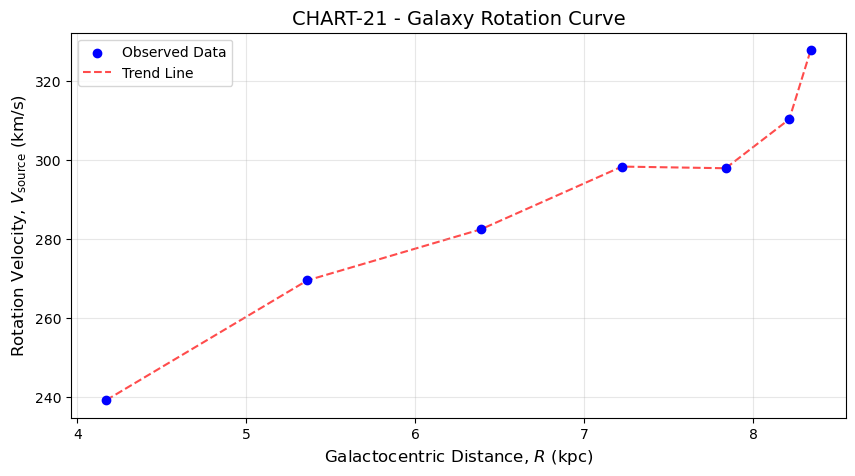

In [147]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Given Data
l_deg = np.array([30, 40, 50, 60, 70, 80, 90])  # Galactic longitude (degrees)
v_ob = np.array([111.47, 105.39, 86.88, 77.25, 58.03, 58.93, 72.54])  # Observed velocities (km/s)

#  Constants
v0 = 255.2  # Sun's circular velocity (km/s)

R0 = 8.34   # Distance of the Sun from the Galactic center (kpc)

# Convert longitude to radians
l_rad = l_deg*np.pi/180

# Compute Galactocentric distances (R) and rotation velocities (Vs)
R = R0 * np.sin(l_rad)
Vs = v_ob + v0 * np.sin(l_rad)

# Plot Rotation Curve
plt.figure(figsize=(10, 5))
plt.scatter(R, Vs, label="Observed Data", color='blue', zorder=2)
plt.plot(R, Vs, linestyle='--', color='red', alpha=0.7, label="Trend Line", zorder=1)



# Enhancing Visualization
plt.grid(alpha=0.3)
plt.xlabel(r'Galactocentric Distance, $R$ (kpc)', fontsize=12)
plt.ylabel(r'Rotation Velocity, $V_{\rm source}$ (km/s)', fontsize=12)
plt.title("CHART-21 - Galaxy Rotation Curve", fontsize=14)
plt.legend()
plt.show()



In [3417]:
import numpy as np
import math
from astropy.coordinates import ICRS, EarthLocation, AltAz, SkyCoord
from astropy.time import Time
import astropy.units as u
from PyAstronomy import pyasl  # Ensure PyAstronomy is installed

def sub_lsr_velocity(az, el, lat, lon, alt, ist_time, v_obs):
    """
    Convert Azimuth/Elevation to LSR velocity correction.

    Parameters:
    az (float): Azimuth in degrees
    el (float): Elevation in degrees
    lat (float): Latitude of observer in degrees
    lon (float): Longitude of observer in degrees
    alt (float): Altitude of observer in meters
    ist_time (str): Observation time in 'YYYY-MM-DD HH:MM:SS' IST format
    v_obs (array): Observed velocity from Doppler shift (km/s)

    Returns:
    array: LSR-corrected velocity (km/s)
    """
    # Define observer location
    location = EarthLocation(lat=lat * u.deg, lon=lon * u.deg, height=alt * u.m)

    # Convert IST to UTC (IST = UTC + 5:30)
    ist_time = Time(ist_time)  # Input is in IST
    utc_time = ist_time - 5.5 * u.hour  # Convert to UTC
    time = utc_time

    print(f"IST Time: {ist_time.iso}")
    print(f"UTC Time: {utc_time.iso}")

    # Compute Local Sidereal Time (LST)
    lst = time.sidereal_time('apparent', longitude=lon * u.deg)

    # Convert Az/El to RA/Dec
    source_altaz = SkyCoord(az=az * u.deg, alt=el * u.deg, frame=AltAz(obstime=time, location=location))
    source_radec = source_altaz.transform_to(ICRS)
    ra, dec = source_radec.ra.deg, source_radec.dec.deg  # Right Ascension & Declination

    print(f"RA: {ra:.4f} deg, DEC: {dec:.4f} deg")

    # Convert observation time to Julian Date
    jd = time.jd
    print(f"Julian Date (JD): {jd:.6f}")

    # Compute Barycentric correction using PyAstronomy
    corr_pyasl, hjd = pyasl.helcorr(lon, lat, alt, ra, dec, jd, debug=False)
    
    # Compute Barycentric correction using Astropy (Fixed)
    radec = SkyCoord(ra=ra * u.deg, dec=dec * u.deg, frame="icrs")
    barycorr_astropy = radec.radial_velocity_correction(obstime=time, location=location)
    corr_astropy = barycorr_astropy.to(u.km / u.s).value

    print(f"PyAstronomy Barycentric Correction: {corr_pyasl:.4f} km/s")
    print(f"Astropy Barycentric Correction: {corr_astropy:.4f} km/s")

    # Compute Solar Apex motion correction
    v_sun = 20.5  # km/s (Sun's motion relative to LSR)
    sun_ra, sun_dec = math.radians(270.2), math.radians(28.7)
    obs_ra, obs_dec = math.radians(ra), math.radians(dec)

    a = math.cos(sun_dec) * math.cos(obs_dec)
    b = (math.cos(sun_ra) * math.cos(obs_ra)) + (math.sin(sun_ra) * math.sin(obs_ra))
    c = math.sin(sun_dec) * math.sin(obs_dec)
    v_rs = v_sun * ((a * b) + c)

    print(f"Solar Motion Correction (V_rs): {v_rs:.4f} km/s")

    # Compute final LSR velocity correction using PyAstronomy
    v_lsr_pyasl = corr_pyasl + v_rs
    # Compute final LSR velocity correction using Astropy
    v_lsr_astropy = corr_astropy + v_rs

    print(f"LSR Correction (PyAstronomy): {v_lsr_pyasl:.4f} km/s")
    print(f"LSR Correction (Astropy): {v_lsr_astropy:.4f} km/s")

    # Compute LSR-corrected velocity
    v_lsr_corrected_pyasl = v_obs - v_lsr_pyasl
    v_lsr_corrected_astropy = v_obs - v_lsr_astropy

    return v_lsr_corrected_pyasl, v_lsr_corrected_astropy  # Return both corrections


In [2933]:
az = 180.0  # Azimuth in degrees
el = 45.0  # Elevation in degrees
lat = 18.52  # Observer latitude (e.g., Pune, India)
lon = 73.85  # Observer longitude
alt = 560  # Altitude in meters
ist_time = "2025-03-14 17:30:00"  # IST observation time (5:30 PM IST)
v_obs = np.array([0, 50, 100, 150, 200])  # Example observed velocities

v_lsr_pyasl, v_lsr_astropy = sub_lsr_velocity(az, el, lat, -lon, alt, ist_time, v_obs)
print("LSR-Corrected Velocity (PyAstronomy):", v_lsr_pyasl)
print("LSR-Corrected Velocity (Astropy):", v_lsr_astropy)


IST Time: 2025-03-14 17:30:00.000
UTC Time: 2025-03-14 12:00:00.000
RA: 278.1184 deg, DEC: -26.4978 deg
Julian Date (JD): 2460749.000000
PyAstronomy Barycentric Correction: 28.9663 km/s
Astropy Barycentric Correction: 28.9712 km/s
Solar Motion Correction (V_rs): 11.5469 km/s
LSR Correction (PyAstronomy): 40.5132 km/s
LSR Correction (Astropy): 40.5181 km/s
LSR-Corrected Velocity (PyAstronomy): [-40.51318795   9.48681205  59.48681205 109.48681205 159.48681205]
LSR-Corrected Velocity (Astropy): [-40.51805841   9.48194159  59.48194159 109.48194159 159.48194159]


In [2991]:
from astropy.coordinates import SkyCoord
import astropy.units as u

gal = SkyCoord(l=90*u.deg, b=0*u.deg, frame='galactic')
icrs = gal.transform_to('icrs')

print(f"RA: {icrs.ra}, Dec: {icrs.dec}")


RA: 318.00438150701746 deg, Dec: 48.329637206840914 deg


In [4043]:
#!/usr/bin/env python
# coding: utf-8

# In[9]:

# PyAstronomy package requireq: https://pyastronomy.readthedocs.io/en/latest/index.html

from __future__ import print_function, division
from PyAstronomy import pyasl
import math
import datetime

# Coordinates of telescope
longitude = 78.2634
latitude = 18.0460
altitude = 554

# Coordinates of source (RA2000, DEC2000) RA_hr RA_min RA_sec DEC_deg DEC_min DEC_sec. Note DEC must be signed + or -.
hd1 = "21 15 35.56 +47 58 13.7"
obs_ra_2000, obs_dec_2000 = pyasl.coordsSexaToDeg(hd1)

# Time of observation converted to Julian Date
dt = datetime.datetime(2025, 3, 12, 4, 4, 43)
jd = pyasl.jdcnv(dt)

# Calculate barycentric correction (debug=True show
# various intermediate results)
corr, hjd = pyasl.helcorr(longitude, latitude, altitude, obs_ra_2000, obs_dec_2000, jd, debug=True)

#print("Barycentric correction [km/s]: ", corr)
#print("Heliocentric Julian day: ", hjd)

# Calculate LSR correction
v_sun = 20.5 # peculiar velocity (km/s) of sun w.r.t. LSR (The Solar Apex. Nature 162, 920 (1948). https://doi.org/10.1038/162920a0)
# solar apex
sun_ra = math.radians(270.2)
sun_dec = math.radians(28.7)

obs_dec = math.radians(obs_dec_2000)
obs_ra = math.radians(obs_ra_2000)

# equation from https://icts-yebes.oan.es/reports/doc/IT-CDT-2014-10.pdf
a = math.cos(sun_dec) * math.cos(obs_dec)
b = (math.cos(sun_ra) * math.cos(obs_ra)) + (math.sin(sun_ra) * math.sin(obs_ra))
c = math.sin(sun_dec) * math.sin(obs_dec)
v_rs = v_sun * ((a * b) + c)

v_lsr = corr + v_rs
print("LSR correction [km/s]: ", -v_lsr)
print("Positive value means receding (redshift) source, negative value means approaching (blueshift) source")
print("lsr: ", v_lsr)



----- HELCORR.PRO - DEBUG INFO - START ----
(obs_long (East positive),obs_lat,obs_alt) Observatory coordinates [deg,m]:  78.2634 18.046 554
(ra,dec) Object coordinates (for epoch 2000.0) [deg]:  318.89816666666667 47.97047222222223
(ra,dec) Object coordinates (precessed to epoch 2025.282877) [deg]:  319.1194989084969 48.07671597357584
(ut) Universal time (middle of exposure) [hrs]:  4.078611105680466
(jd) Julian date (middle of exposure) (JD):  2460746.6699421294
(hjd) Heliocentric Julian date (middle of exposure) (HJD):  2460746.6669855304
(gmst) Greenwich mean sidereal time [hrs]:  15.416103562959506
(lmst) Local mean sidereal time [hrs]:  20.633663562959555
(dlat) Latitude correction [deg]:  -406.9784513200719
(lat) Geocentric latitude of observer [deg]:  17.932950430188868
(r) Distance of observer from center of earth [m]:  6376701.943730833
(v) Rotational velocity of earth at the position of the observer [km/s]:  0.4649964934974371
(vdiurnal) Projected earth rotation and earth-mo

In [4013]:
from astropy.coordinates import AltAz, EarthLocation, ICRS
from astropy.time import Time
import astropy.units as u

# Given observation details
azimuth = 12 * u.deg
elevation = 58 * u.deg
latitude = 18.0460 * u.deg
longitude = 78.2634 * u.deg
altitude = 474 * u.m
obs_time = Time("2025-03-12 09:34:00")

# Define observation location
obs_location = EarthLocation(lat=latitude, lon=longitude, height=altitude)

# Define AltAz frame at observation time and location
altaz_coord = AltAz(az=azimuth, alt=elevation, obstime=obs_time, location=obs_location)
radec_coord = altaz_coord.transform_to(ICRS())

# Extract RA and Dec
ra_j2000 = radec_coord.ra.to_string(unit=u.hour, sep=':')
dec_j2000 = radec_coord.dec.to_string(unit=u.degree, sep=':')

print("RA (J2000):", ra_j2000)
print("Dec (J2000):", dec_j2000)


RA (J2000): 2:45:14.62723923
Dec (J2000): 48:57:53.34544637
